In [2]:
import pandas as pd
import numpy as np
from scipy.signal import welch
from scipy.signal import find_peaks
from scipy.integrate import trapz


# HRV

## Original

In [4]:
# Load RR intervals from the file
rr_intervals = pd.read_csv('PCS30_CTRL_RRIntervals.csv')  # Replace with your file name
rr_intervals = rr_intervals[' rr'].values  # Assuming the column is named 'RR_intervals'

# Calculate SDNN
sdnn = np.std(rr_intervals)

# Calculate RMSSD
differences = np.diff(rr_intervals)
rmssd = np.sqrt(np.mean(differences ** 2))

# Calculate Heart Rate
heart_rate = 60000 / np.mean(rr_intervals)  # Assuming RR intervals are in milliseconds

# Calculate LF and HF
time = np.cumsum(rr_intervals) / 1000.0  # Convert to seconds
fs = 4.0  # Sampling frequency (Hz)
f, psd = welch(rr_intervals, fs=fs, nperseg=1024)
lf_band = (0.04, 0.15)  # Low-frequency band
hf_band = (0.15, 0.4)   # High-frequency band
lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
total_power = lf_power + hf_power
lf_percent = (lf_power / total_power) * 100
hf_percent = (hf_power / total_power) * 100
lf_hf_ratio = lf_power / hf_power

print(f"SDNN: {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")
print(f"Heart Rate: {heart_rate:.2f} bpm")
print(f"LF%: {lf_percent:.2f}%")
print(f"HF%: {hf_percent:.2f}%")
print(f"LF/HF Ratio: {lf_hf_ratio:.2f}")

SDNN: 48.36 ms
RMSSD: 22.16 ms
Heart Rate: 61.45 bpm
LF%: 54.29%
HF%: 45.71%
LF/HF Ratio: 1.19


c:\ProgramData\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 804, using nperseg = 804
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


## CREATE NEW CSV FILES FOR KUBOS

In [9]:
import pandas as pd
import glob

# List all CSVs
csv_files = glob.glob("*RRInterval*.csv")

for file_path in csv_files:
    # Read CSV and drop empty rows
    df = pd.read_csv(file_path).dropna(how='all')
    
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Keep only the 'rr' column
    if 'rr' not in df.columns:
        raise ValueError(f"'rr' column not found in {file_path}")
    
    rr_df = df[['rr']].copy()
    
    # Count original RRIs
    original_count = len(rr_df)
    
    # Remove physiologically implausible RRIs
    rr_df = rr_df[(rr_df['rr'] >= 200) & (rr_df['rr'] <= 2000)]
    
    removed_count = original_count - len(rr_df)
    
    # Generate new filename
    new_name = file_path.replace("_RRIntervals.csv", "_RR_clean.csv")
    
    # Save cleaned CSV
    rr_df.to_csv(new_name, index=False)
    
    print(f"Processed {file_path} -> {new_name} | Removed {removed_count} RRIs")


Processed PCS01_V1_RRIntervals.csv -> PCS01_V1_RR_clean.csv | Removed 0 RRIs
Processed PCS01_V2_RRIntervals.csv -> PCS01_V2_RR_clean.csv | Removed 0 RRIs
Processed PCS02_V1_RRIntervals.csv -> PCS02_V1_RR_clean.csv | Removed 0 RRIs
Processed PCS02_V2_RRIntervals.csv -> PCS02_V2_RR_clean.csv | Removed 0 RRIs
Processed PCS03_V1 _RRIntervals.csv -> PCS03_V1 _RR_clean.csv | Removed 0 RRIs
Processed PCS03_V2_RRIntervals.csv -> PCS03_V2_RR_clean.csv | Removed 0 RRIs
Processed PCS05_V1_RRIntervals.csv -> PCS05_V1_RR_clean.csv | Removed 0 RRIs
Processed PCS05_V2_RRIntervals.csv -> PCS05_V2_RR_clean.csv | Removed 0 RRIs
Processed PCS06_V1_RRIntervals.csv -> PCS06_V1_RR_clean.csv | Removed 0 RRIs
Processed PCS06_V2_RRIntervals.csv -> PCS06_V2_RR_clean.csv | Removed 0 RRIs
Processed PCS07_V1_RRIntervals.csv -> PCS07_V1_RR_clean.csv | Removed 0 RRIs
Processed PCS07_V2_RRIntervals.csv -> PCS07_V2_RR_clean.csv | Removed 0 RRIs
Processed PCS08_V1_RRIntervals.csv -> PCS08_V1_RR_clean.csv | Removed 0 RR

## Import from Kubos back to CSV

In [ ]:
import pandas as pd
import glob

# Step 1: List all Kubios CSV files
kubios_files = glob.glob("*_RR_clean_hrv.csv")  # adjust pattern if needed

# Step 2: Metrics we want to extract
metrics = [
    'Mean RR  (ms)',
    'Mean HR (beats/min)',
    'SDNN (ms)',
    'RMSSD (ms)',
    'pNNxx (%)',
    'RR tri index',
    'TINN (ms)',
    'LF (ms^2)',
    'HF (ms^2)',
    'LF (n.u.)',
    'HF (n.u.)',
    'LF/HF ratio',
    'SD1 (ms)',
    'SD2 (ms)',
    'Approximate entropy (ApEn)',
    'Sample entropy (SampEn)',
    'alpha 1',
    'alpha 2'
]

all_data = []

for file in kubios_files:
    # Parse subject_id and visit from filename
    filename = file.split(".csv")[0]
    parts = filename.split("_")
    subject_id = parts[0]
    visit = parts[1]
    
    # Read CSV (two columns only, ignore extras)
    df = pd.read_csv(file, header=None, names=['Parameter', 'Value'], usecols=[0,1])
    
    # Remove empty rows and strip whitespace
    df = df.dropna().copy()
    df['Parameter'] = df['Parameter'].str.strip()
    
    # Build data dictionary
    data_row = {'subject_id': subject_id, 'visit': visit}
    for m in metrics:
        # Remove colons and strip again for matching
        df['Parameter_clean'] = df['Parameter'].str.replace(':','').str.strip()
        match = df.loc[df['Parameter_clean'] == m, 'Value']
        if not match.empty:
            try:
                data_row[m] = float(match.values[0])
            except:
                data_row[m] = None
        else:
            data_row[m] = None
    
    all_data.append(data_row)

# Combine all subjects into one DataFrame
final_df = pd.DataFrame(all_data)

# Save REDCap-ready CSV
final_df.to_csv("HRV_REDCap_upload.csv", index=False)

print("REDCap-ready CSV saved!")


REDCap-ready CSV saved!


In [21]:
import pandas as pd
import glob

# Step 1: List all Kubios CSV files
kubios_files = glob.glob("*_RR_clean_hrv.csv")  # adjust pattern if needed

# Step 2: Metrics we want to extract
metric_map = {
    'Mean RR  (ms)': 'hrv_meanrr',
    'SDNN (ms)': 'hrv_sdnn',
    'Mean HR (beats/min)': 'hrv_heartrate',
    'RMSSD (ms)': 'hrv_rmssd',
    'pNNxx (%)': 'hrv_pnn',
    'RR tri index': 'hrv_rrtriindex',
    'TINN (ms)': 'hrv_tinn',
    'LF (ms^2)': 'hrv_lf_ms',
    'HF (ms^2)': 'hrv_hf_ms',
    'LF (%)': 'hrv_lf_percent',
    'HF (%)': 'hrv_hf_percent',
    'LF/HF ratio': 'hrv_lfhf',
    'SD1 (ms)': 'hrv_sd1',
    'SD2 (ms)': 'hrv_sd2',
    'Approximate entropy (ApEn)': 'hrv_apen',
    'Sample entropy (SampEn)': 'hrv_sampen',
    'alpha 1': 'hrv_a1',
    'alpha 2': 'hrv_a2'
}

all_data = []

for file in kubios_files:
    # Parse subject_id and visit from filename
    filename = file.split(".csv")[0]
    parts = filename.split("_")
    subject_id = parts[0]
    visit = parts[1]
    
    # Read CSV (two columns only, ignore extras)
    df = pd.read_csv(file, header=None, names=['Parameter', 'Value'], usecols=[0,1])
    
    # Remove empty rows and strip whitespace
    df = df.dropna().copy()
    df['Parameter'] = df['Parameter'].str.strip()
    
    # Build data dictionary
    data_row = {'subject_id': subject_id, 'visit': visit}
    for kubios_metric, redcap_var in metric_map.items():
        df['Parameter_clean'] = df['Parameter'].str.replace(':','').str.strip()
        match = df.loc[df['Parameter_clean'] == kubios_metric, 'Value']
        if not match.empty:
            try:
                data_row[redcap_var] = float(match.values[0])
            except:
                data_row[redcap_var] = None
        else:
            data_row[redcap_var] = None
    
    all_data.append(data_row)

# Combine all subjects into one DataFrame
final_df = pd.DataFrame(all_data)

# Save REDCap-ready CSV
final_df.to_csv("HRV_REDCap_upload.csv", index=False)

print("REDCap-ready CSV saved!")


REDCap-ready CSV saved!


# CPET

## Anaerobic Threshold

In [28]:

# Import CPET data for anaerobic threshold analysis
df_cpet = pd.read_csv("PCS15_V1_CPET.csv", header=0)

# Remove any spaces in the names of the columns
df_cpet.columns = df_cpet.columns.str.replace(' ', '')

# Display the first few rows
print(df_cpet.head())


# Assuming df_cpet has columns: 'VO2', 'VCO2', 'VE', 'VE/VO2', 'VE/VCO2'
# calculate the first derivative of VE/VO2 and VE/VCO2 to find the inflection points.

# Calculate the derivative of VE/VO2 and VE/VCO2
df_cpet['dVE_VO2'] = np.gradient(df_cpet['VE/VO2'])
df_cpet['dVE_VCO2'] = np.gradient(df_cpet['VE/VCO2'])

# Find peaks in the derivative which correspond to the anaerobic threshold
peaks_VO2 = find_peaks(df_cpet['dVE_VO2'])[0]
peaks_VCO2 = find_peaks(df_cpet['dVE_VCO2'])[0]

# Assuming the anaerobic threshold is at the first peak (can be adjusted based on the data)
at_VO2 = df_cpet['VO2'].iloc[peaks_VO2[0]] if len(peaks_VO2) > 0 else None

print(f"Anaerobic Threshold (VO2): {at_VO2}")


   TIME  VO2/kg   VO2  VCO2     VE   RER  O2Pulse  RR    Vt  HR  WorkR  HR.1  \
0  0:30     1.6  0.14  0.11  12.70  0.78        0  14  0.92   0      0     0   
1  1:05     4.5  0.38  0.29  11.11  0.76        0  12  0.94   0      0     0   
2  1:30     7.8  0.66  0.46  14.59  0.70        0  12  1.18   0      0     0   
3  2:03     8.4  0.71  0.50  16.04  0.70        0  16  1.00   0      0     0   
4  2:33     7.7  0.64  0.47  14.66  0.73        0  12  1.20   0      0     0   

   VE/VCO2  VE/VO2  PetCO2  
0      118      92      10  
1       39      29      25  
2       32      22      29  
3       32      23      29  
4       31      23      30  
Anaerobic Threshold (VO2): 0.71


# V2

In [18]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

# Import and clean data
df_cpet = pd.read_csv("PCS26_CTRL_CPET.csv", header=0)
df_cpet.columns = df_cpet.columns.str.replace(' ', '')
print(df_cpet.head())

# Dictionary to store results
results = {}

def safe_max(series):
    clean_series = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    return clean_series.max()

# Find row with peak VO2 for parameter calculations
if 'VO2' in df_cpet.columns:
    vo2_peak_abs = safe_max(df_cpet['VO2'])  # assume VO2 is already in L/min
    peak_vo2_row = df_cpet[df_cpet['VO2'] == vo2_peak_abs].iloc[0] if not pd.isna(vo2_peak_abs) else None
else:
    peak_vo2_row = None

# Anaerobic Threshold Calculation (with %VO2peak)
try:
    if all(col in df_cpet.columns for col in ['VE/VO2', 'VE/VCO2', 'VO2']):
        df_cpet['dVE_VO2'] = np.gradient(df_cpet['VE/VO2'])
        df_cpet['dVE_VCO2'] = np.gradient(df_cpet['VE/VCO2'])
        
        peaks_VO2 = find_peaks(df_cpet['dVE_VO2'])[0]
        if len(peaks_VO2) > 0:
            at_vo2 = df_cpet['VO2'].iloc[peaks_VO2[0]]
            results['Anaerobic Threshold (VO2)'] = f"{at_vo2:.2f} L/min"
            if vo2_peak_abs and vo2_peak_abs > 0:
                at_pct = (at_vo2 / vo2_peak_abs) * 100
                results['Anaerobic Threshold (%VO2peak)'] = f"{at_pct:.1f} %"
        else:
            results['Anaerobic Threshold (VO2)'] = "Could not determine"
    else:
        missing = [col for col in ['VE/VO2', 'VE/VCO2', 'VO2'] if col not in df_cpet.columns]
        results['Anaerobic Threshold (VO2)'] = f"Missing columns: {', '.join(missing)}"
except Exception as e:
    results['Anaerobic Threshold (VO2)'] = f"Calculation error: {str(e)}"

# VO2 Peak Calculations
if 'VO2' in df_cpet.columns:
    results['VO2 Peak (absolute)'] = f"{vo2_peak_abs:.2f} L/min" if not pd.isna(vo2_peak_abs) else "Invalid VO2 data"
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = peak_vo2_row['VO2/kg'] if peak_vo2_row is not None else safe_max(df_cpet['VO2/kg'])
        results['VO2 Peak (relative)'] = f"{vo2_peak_rel:.2f} mL/kg/min" if not pd.isna(vo2_peak_rel) else "Invalid VO2/kg data"
    else:
        results['VO2 Peak (relative)'] = "VO2/kg column missing"
else:
    results['VO2 Peak (absolute)'] = "VO2 column missing"
    results['VO2 Peak (relative)'] = "VO2 column missing"

# Parameter calculations at peak VO2
parameter_map = {
    'Peak HR': ('HR', 'bpm'),
    'Peak VE': ('VE', 'L/min'),
    'Peak VE/VO2': ('VE/VO2', ''),
    'Peak O2 Pulse': ('O2pulse', 'mL/beat'),
    'Peak RER': ('RER', ''),
    'Peak Respiratory Rate': ('RR', 'breaths/min'),
    'Peak PetCO2': ('PetCO2', 'mmHg'),
    'Peak Tidal Volume': ('Vt', 'L')
}

for param, (col, unit) in parameter_map.items():
    if col in df_cpet.columns:
        if peak_vo2_row is not None:
            value = peak_vo2_row[col]
            results[param] = f"{value:.2f} {unit}" if unit else f"{value:.2f}"
        else:
            value = safe_max(df_cpet[col]) if 'Peak' in param else df_cpet[col].iloc[-1]
            results[param] = f"{value:.2f} {unit}" if not pd.isna(value) else f"Invalid {col} data"
    else:
        results[param] = f"{col} column missing"

# Calculate O2_Pulse if not in original data but we have VO2 and HR
if 'O2_Pulse' not in df_cpet.columns and all(col in df_cpet.columns for col in ['VO2', 'HR']):
    df_cpet['O2_Pulse'] = np.where(df_cpet['HR'] > 0, df_cpet['VO2'] / df_cpet['HR'], np.nan)

# Calculate OUES (Oxygen Uptake Efficiency Slope)
if all(col in df_cpet.columns for col in ['VO2', 'VE']):
    df_oues = df_cpet[(df_cpet['VE'] > 0) & (df_cpet['VO2'] > 0)].copy()
    df_oues['log10_VE'] = np.log10(df_oues['VE'])

    try:
        X = df_oues['log10_VE'].values.reshape(-1, 1)
        y = df_oues['VO2'].values  # already in L/min
        reg = LinearRegression().fit(X, y)
        oues_slope = reg.coef_[0]
        r_squared = reg.score(X, y)

        results['OUES'] = f"{oues_slope:.3f} L/min (R²={r_squared:.3f})"
    except Exception as e:
        results['OUES'] = f"Calculation error: {str(e)}"
else:
    missing = [col for col in ['VO2', 'VE'] if col not in df_cpet.columns]
    results['OUES'] = f"Missing columns: {', '.join(missing)}"

# Print formatted results
print("\nCPET Analysis Results:")
max_len = max(len(k) for k in results.keys())
for param in sorted(results.keys()):
    print(f"{param.ljust(max_len)} : {results[param]}")


       TIME     VO2/kg       VO2      VCO2         VE       RER     RER.1  \
0  0.535333   7.665530  0.518956  0.341332  10.886865  0.657727  0.657727   
1  1.022333   9.333255  0.631861  0.382477  11.522161  0.605317  0.605317   
2  1.525500  11.291279  0.764420  0.466343  12.818426  0.610062  0.610062   
3  2.078667  11.852171  0.802392  0.523886  13.907189  0.652906  0.652906   
4  2.520167  10.912728  0.738792  0.506854  13.651427  0.686058  0.686058   

          RR        Vt     HR  WorkR   HR.1    VE/VCO2    VE/VO2       FEO2  \
0  16.811954  0.647567  102.0      0  102.0  31.895271  1.420236  15.598834   
1  14.373717  0.801613  103.0      0  103.0  30.125141  1.234528  14.868010   
2  11.924479  1.074967  105.0      0  105.0  27.487095  1.135250  14.329860   
3  16.269960  0.854777  110.0      0  110.0  26.546190  1.173388  14.482229   
4  11.325028  1.205421  107.0      0  107.0  26.933670  1.250964  14.837352   

      FECO2  
0  3.825042  
1  4.047659  
2  4.432268  
3  4.5

## NEW

In [19]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

# Import and clean data
df_cpet = pd.read_csv("PCS01_V1_CPET.csv", header=0)
df_cpet.columns = df_cpet.columns.str.replace(' ', '')

# Dictionary to store results
results = {}

def safe_max(series):
    clean_series = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    return clean_series.max()

# Convert VO2 to mL/min for O2 pulse calculation
if 'VO2' in df_cpet.columns:
    df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000  # convert to mL/min

# Calculate O2 Pulse if missing and VO2 + HR available
if 'O2pulse' not in df_cpet.columns and all(col in df_cpet.columns for col in ['VO2', 'HR']):
    df_cpet['O2pulse'] = np.where(df_cpet['HR'] > 0, df_cpet['VO2_mL'] / df_cpet['HR'], np.nan)

# Calculate Respiratory Rate if missing and VE + Vt available
if 'RR' not in df_cpet.columns and all(col in df_cpet.columns for col in ['VE', 'Vt']):
    df_cpet['RR'] = np.where(df_cpet['Vt'] > 0, df_cpet['VE'] / df_cpet['Vt'], np.nan)

# Find row with peak VO2 for parameter calculations
if 'VO2' in df_cpet.columns:
    vo2_peak_abs = safe_max(df_cpet['VO2'])  # assume VO2 is already in L/min
    peak_vo2_row = df_cpet[df_cpet['VO2'] == vo2_peak_abs].iloc[0] if not pd.isna(vo2_peak_abs) else None
else:
    peak_vo2_row = None

# Anaerobic Threshold Calculation (with %VO2peak)
try:
    if all(col in df_cpet.columns for col in ['VE/VO2', 'VE/VCO2', 'VO2']):
        df_cpet['dVE_VO2'] = np.gradient(df_cpet['VE/VO2'])
        df_cpet['dVE_VCO2'] = np.gradient(df_cpet['VE/VCO2'])
        
        peaks_VO2 = find_peaks(df_cpet['dVE_VO2'])[0]
        if len(peaks_VO2) > 0:
            at_vo2 = df_cpet['VO2'].iloc[peaks_VO2[0]]
            results['Anaerobic Threshold (VO2)'] = f"{at_vo2:.2f} L/min"
            if vo2_peak_abs and vo2_peak_abs > 0:
                at_pct = (at_vo2 / vo2_peak_abs) * 100
                results['Anaerobic Threshold (%VO2peak)'] = f"{at_pct:.1f} %"
        else:
            results['Anaerobic Threshold (VO2)'] = "Could not determine"
    else:
        missing = [col for col in ['VE/VO2', 'VE/VCO2', 'VO2'] if col not in df_cpet.columns]
        results['Anaerobic Threshold (VO2)'] = f"Missing columns: {', '.join(missing)}"
except Exception as e:
    results['Anaerobic Threshold (VO2)'] = f"Calculation error: {str(e)}"

# VO2 Peak Calculations
if 'VO2' in df_cpet.columns:
    results['VO2 Peak (absolute)'] = f"{vo2_peak_abs:.2f} L/min" if not pd.isna(vo2_peak_abs) else "Invalid VO2 data"
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = peak_vo2_row['VO2/kg'] if peak_vo2_row is not None else safe_max(df_cpet['VO2/kg'])
        results['VO2 Peak (relative)'] = f"{vo2_peak_rel:.2f} mL/kg/min" if not pd.isna(vo2_peak_rel) else "Invalid VO2/kg data"
    else:
        results['VO2 Peak (relative)'] = "VO2/kg column missing"
else:
    results['VO2 Peak (absolute)'] = "VO2 column missing"
    results['VO2 Peak (relative)'] = "VO2 column missing"

# Parameter calculations at peak VO2
parameter_map = {
    'Peak HR': ('HR', 'bpm'),
    'Peak VE': ('VE', 'L/min'),
    'Peak VE/VO2': ('VE/VO2', ''),
    'Peak O2 Pulse': ('O2pulse', 'mL/beat'),
    'Peak RER': ('RER', ''),
    'Peak Respiratory Rate': ('RR', 'breaths/min'),
    'Peak PetCO2': ('PetCO2', 'mmHg'),
    'Peak Tidal Volume': ('Vt', 'L')
}

for param, (col, unit) in parameter_map.items():
    if col in df_cpet.columns:
        if peak_vo2_row is not None:
            value = peak_vo2_row[col]
            results[param] = f"{value:.2f} {unit}" if unit else f"{value:.2f}"
        else:
            value = safe_max(df_cpet[col]) if 'Peak' in param else df_cpet[col].iloc[-1]
            results[param] = f"{value:.2f} {unit}" if not pd.isna(value) else f"Invalid {col} data"
    else:
        results[param] = f"{col} column missing"

# Calculate OUES (Oxygen Uptake Efficiency Slope)
if all(col in df_cpet.columns for col in ['VO2', 'VE']):
    df_oues = df_cpet[(df_cpet['VE'] > 0) & (df_cpet['VO2'] > 0)].copy()
    df_oues['log10_VE'] = np.log10(df_oues['VE'])

    try:
        X = df_oues['log10_VE'].values.reshape(-1, 1)
        y = df_oues['VO2'].values  # already in L/min
        reg = LinearRegression().fit(X, y)
        oues_slope = reg.coef_[0]
        r_squared = reg.score(X, y)

        results['OUES'] = f"{oues_slope:.3f} L/min (R²={r_squared:.3f})"
    except Exception as e:
        results['OUES'] = f"Calculation error: {str(e)}"
else:
    missing = [col for col in ['VO2', 'VE'] if col not in df_cpet.columns]
    results['OUES'] = f"Missing columns: {', '.join(missing)}"

# Print formatted results
print("\nCPET Analysis Results:")
max_len = max(len(k) for k in results.keys())
for param in sorted(results.keys()):
    print(f"{param.ljust(max_len)} : {results[param]}")



CPET Analysis Results:
Anaerobic Threshold (%VO2peak) : 30.3 %
Anaerobic Threshold (VO2)      : 0.58 L/min
OUES                           : 1.911 L/min (R²=0.975)
Peak HR                        : 0.00 bpm
Peak O2 Pulse                  : nan mL/beat
Peak PetCO2                    : PetCO2 column missing
Peak RER                       : 0.94
Peak Respiratory Rate          : 33.08 breaths/min
Peak Tidal Volume              : 1.50 L
Peak VE                        : 49.71 L/min
Peak VE/VO2                    : 26.17
VO2 Peak (absolute)            : 1.90 L/min
VO2 Peak (relative)            : 24.99 mL/kg/min


In [20]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# --- Load and clean data ---
df_cpet = pd.read_csv("PCS01_V1_CPET.csv", header=0)
df_cpet.columns = df_cpet.columns.str.replace(' ', '')

# Dictionary to store results
results = {}

def safe_max(series):
    clean_series = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    return clean_series.max()

# Peak VO2 detection
if 'VO2' in df_cpet.columns:
    vo2_peak_abs = safe_max(df_cpet['VO2'])
    peak_vo2_row = df_cpet[df_cpet['VO2'] == vo2_peak_abs].iloc[0] if not pd.isna(vo2_peak_abs) else None
else:
    peak_vo2_row = None
    vo2_peak_abs = None

# --- Ventilatory Equivalent Method with smoothing and VE/VCO2 check ---
def calculate_vent_equiv_AT(df):
    # Check required columns
    required_cols = ['VE/VO2', 'VE/VCO2', 'VO2']
    if not all(col in df.columns for col in required_cols):
        missing = [c for c in required_cols if c not in df.columns]
        return None, f"Missing columns: {', '.join(missing)}"
    
    # Smooth VE/VO2 and VE/VCO2
    df['VE/VO2_smooth'] = df['VE/VO2'].rolling(window=3, center=True).mean()
    df['VE/VCO2_smooth'] = df['VE/VCO2'].rolling(window=3, center=True).mean()
    
    # Drop NaNs created by rolling
    df_clean = df.dropna(subset=['VE/VO2_smooth', 'VE/VCO2_smooth', 'VO2']).reset_index(drop=True)
    
    # Calculate gradients
    dVE_VO2 = np.gradient(df_clean['VE/VO2_smooth'])
    dVE_VCO2 = np.gradient(df_clean['VE/VCO2_smooth'])
    
    peaks = find_peaks(dVE_VO2)[0]
    
    at_vo2 = None
    for peak in peaks:
        # Check VE/VCO2 slope before and after peak
        start = max(peak - 3, 0)
        end = min(peak + 4, len(dVE_VCO2))
        pre_slope = np.mean(dVE_VCO2[start:peak+1])
        post_slope = np.mean(dVE_VCO2[peak:end])
        
        # Accept if VE/VCO2 slope does NOT increase
        if post_slope <= pre_slope:
            at_vo2 = df_clean['VO2'].iloc[peak]
            break

    if at_vo2:
        return at_vo2, None
    else:
        return None, "Could not determine AT via ventilatory equivalent method"

# Calculate ventilatory equivalent AT
at_vent_eq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
if at_vent_eq:
    results['Anaerobic Threshold (VO2)'] = f"{at_vent_eq:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['Anaerobic Threshold (%VO2peak)'] = f"{(at_vent_eq / vo2_peak_abs) * 100:.1f} %"
else:
    results['Anaerobic Threshold (VO2)'] = vent_eq_err or "Error in calculation"
    results['Anaerobic Threshold (%VO2peak)'] = vent_eq_err or "Error in calculation"

# --- Modified V-Slope Method ---
def calculate_vslope_AT(df):
    if not all(c in df.columns for c in ['VO2', 'VCO2']):
        return None
    df_vs = df[['VO2', 'VCO2']].dropna().reset_index(drop=True)
    n = len(df_vs)
    if n < 10:
        return None
    best_mse = np.inf
    best_idx = None
    for i in range(int(n * 0.2), int(n * 0.8)):
        X1 = df_vs['VO2'][:i].values.reshape(-1, 1)
        y1 = df_vs['VCO2'][:i].values
        X2 = df_vs['VO2'][i:].values.reshape(-1, 1)
        y2 = df_vs['VCO2'][i:].values
        
        reg1 = LinearRegression().fit(X1, y1)
        reg2 = LinearRegression().fit(X2, y2)
        
        pred1 = reg1.predict(X1)
        pred2 = reg2.predict(X2)
        
        mse = mean_squared_error(y1, pred1) + mean_squared_error(y2, pred2)
        
        if mse < best_mse:
            best_mse = mse
            best_idx = i
    
    if best_idx:
        return df_vs['VO2'].iloc[best_idx]
    return None

at_vslope = calculate_vslope_AT(df_cpet)
if at_vslope:
    results['AT (V-slope, absolute)'] = f"{at_vslope:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['AT (V-slope, %VO2peak)'] = f"{(at_vslope / vo2_peak_abs) * 100:.1f} %"
else:
    results['AT (V-slope, absolute)'] = "Could not determine"
    results['AT (V-slope, %VO2peak)'] = "Could not determine"

# --- RER Method (RER >= 1.0 and stays >=1.0) ---
def calculate_rer_AT(df):
    if 'RER' not in df.columns or 'VO2' not in df.columns:
        return None
    rer = df['RER'].values
    vo2 = df['VO2'].values
    for i in range(len(rer)):
        if rer[i] >= 1.0:
            if np.all(rer[i:] >= 1.0):
                return vo2[i]
    return None

at_rer = calculate_rer_AT(df_cpet)
if at_rer:
    results['AT (RER, absolute)'] = f"{at_rer:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['AT (RER, %VO2peak)'] = f"{(at_rer / vo2_peak_abs) * 100:.1f} %"
else:
    results['AT (RER, absolute)'] = "Could not determine"
    results['AT (RER, %VO2peak)'] = "Could not determine"

# --- VO2 Peak Reporting ---
if 'VO2' in df_cpet.columns:
    results['VO2 Peak (absolute)'] = f"{vo2_peak_abs:.2f} L/min" if not pd.isna(vo2_peak_abs) else "Invalid VO2 data"
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = peak_vo2_row['VO2/kg'] if peak_vo2_row is not None else safe_max(df_cpet['VO2/kg'])
        results['VO2 Peak (relative)'] = f"{vo2_peak_rel:.2f} mL/kg/min" if not pd.isna(vo2_peak_rel) else "Invalid VO2/kg data"
    else:
        results['VO2 Peak (relative)'] = "VO2/kg column missing"
else:
    results['VO2 Peak (absolute)'] = "VO2 column missing"
    results['VO2 Peak (relative)'] = "VO2 column missing"

# --- Parameter calculations at peak VO2 ---
parameter_map = {
    'Peak HR': ('HR', 'bpm'),
    'Peak VE': ('VE', 'L/min'),
    'Peak VE/VO2': ('VE/VO2', ''),
    'Peak O2 Pulse': ('O2pulse', 'mL/beat'),
    'Peak RER': ('RER', ''),
    'Peak Respiratory Rate': ('RR', 'breaths/min'),
    'Peak PetCO2': ('PetCO2', 'mmHg'),
    'Peak Tidal Volume': ('Vt', 'L')
}

for param, (col, unit) in parameter_map.items():
    if col in df_cpet.columns:
        if peak_vo2_row is not None:
            value = peak_vo2_row[col]
            results[param] = f"{value:.2f} {unit}" if unit else f"{value:.2f}"
        else:
            value = safe_max(df_cpet[col]) if 'Peak' in param else df_cpet[col].iloc[-1]
            results[param] = f"{value:.2f} {unit}" if not pd.isna(value) else f"Invalid {col} data"
    else:
        results[param] = f"{col} column missing"

# --- Calculate O2 Pulse if missing but VO2 and HR exist ---
if 'O2pulse' not in df_cpet.columns and all(col in df_cpet.columns for col in ['VO2', 'HR']):
    df_cpet['O2pulse'] = np.where(df_cpet['HR'] > 0, df_cpet['VO2'] / df_cpet['HR'], np.nan)

# Calculate Respiratory Rate if missing and VE + Vt available
if 'RR' not in df_cpet.columns and all(col in df_cpet.columns for col in ['VE', 'Vt']):
    df_cpet['RR'] = np.where(df_cpet['Vt'] > 0, df_cpet['VE'] / df_cpet['Vt'], np.nan)


# --- Calculate OUES (Oxygen Uptake Efficiency Slope) ---
if all(col in df_cpet.columns for col in ['VO2', 'VE']):
    df_oues = df_cpet[(df_cpet['VE'] > 0) & (df_cpet['VO2'] > 0)].copy()
    df_oues['log10_VE'] = np.log10(df_oues['VE'])

    try:
        X = df_oues['log10_VE'].values.reshape(-1, 1)
        y = df_oues['VO2'].values  # already in L/min
        reg = LinearRegression().fit(X, y)
        oues_slope = reg.coef_[0]
        r_squared = reg.score(X, y)

        results['OUES'] = f"{oues_slope:.3f} L/min (R²={r_squared:.3f})"
    except Exception as e:
        results['OUES'] = f"Calculation error: {str(e)}"
else:
    missing = [col for col in ['VO2', 'VE'] if col not in df_cpet.columns]
    results['OUES'] = f"Missing columns: {', '.join(missing)}"

# --- Print all results ---
print("\nCPET Analysis Results:")
max_len = max(len(k) for k in results.keys())
for param in sorted(results.keys()):
    print(f"{param.ljust(max_len)} : {results[param]}")



CPET Analysis Results:
AT (RER, %VO2peak)             : Could not determine
AT (RER, absolute)             : Could not determine
AT (V-slope, %VO2peak)         : 57.5 %
AT (V-slope, absolute)         : 1.09 L/min
Anaerobic Threshold (%VO2peak) : 32.1 %
Anaerobic Threshold (VO2)      : 0.61 L/min
OUES                           : 1.911 L/min (R²=0.975)
Peak HR                        : 0.00 bpm
Peak O2 Pulse                  : O2pulse column missing
Peak PetCO2                    : PetCO2 column missing
Peak RER                       : 0.94
Peak Respiratory Rate          : RR column missing
Peak Tidal Volume              : 1.50 L
Peak VE                        : 49.71 L/min
Peak VE/VO2                    : 26.17
VO2 Peak (absolute)            : 1.90 L/min
VO2 Peak (relative)            : 24.99 mL/kg/min


## 3

In [21]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# --- Load and clean data ---
df_cpet = pd.read_csv("PCS01_V1_CPET.csv", header=0)
df_cpet.columns = df_cpet.columns.str.replace(' ', '')

# Dictionary to store results
results = {}

def safe_max(series):
    clean_series = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    return clean_series.max()

# Convert VO2 to mL/min for O2 pulse calculation
if 'VO2' in df_cpet.columns:
    df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000  # convert to mL/min

# Calculate O2 Pulse if missing and VO2 + HR available
if 'O2pulse' not in df_cpet.columns and all(col in df_cpet.columns for col in ['VO2_mL', 'HR']):
    df_cpet['O2pulse'] = np.where(df_cpet['HR'] > 0, df_cpet['VO2_mL'] / df_cpet['HR'], np.nan)

# Calculate Respiratory Rate if missing and VE + Vt available
if 'RR' not in df_cpet.columns and all(col in df_cpet.columns for col in ['VE', 'Vt']):
    df_cpet['RR'] = np.where(df_cpet['Vt'] > 0, df_cpet['VE'] / df_cpet['Vt'], np.nan)

# Peak VO2 detection
if 'VO2' in df_cpet.columns:
    vo2_peak_abs = safe_max(df_cpet['VO2'])
    peak_vo2_row = df_cpet[df_cpet['VO2'] == vo2_peak_abs].iloc[0] if not pd.isna(vo2_peak_abs) else None
else:
    peak_vo2_row = None
    vo2_peak_abs = None

# --- Ventilatory Equivalent Method with smoothing and VE/VCO2 check ---
def calculate_vent_equiv_AT(df):
    required_cols = ['VE/VO2', 'VE/VCO2', 'VO2']
    if not all(col in df.columns for col in required_cols):
        missing = [c for c in required_cols if c not in df.columns]
        return None, f"Missing columns: {', '.join(missing)}"
    
    df['VE/VO2_smooth'] = df['VE/VO2'].rolling(window=3, center=True).mean()
    df['VE/VCO2_smooth'] = df['VE/VCO2'].rolling(window=3, center=True).mean()
    
    df_clean = df.dropna(subset=['VE/VO2_smooth', 'VE/VCO2_smooth', 'VO2']).reset_index(drop=True)
    
    dVE_VO2 = np.gradient(df_clean['VE/VO2_smooth'])
    dVE_VCO2 = np.gradient(df_clean['VE/VCO2_smooth'])
    
    peaks = find_peaks(dVE_VO2)[0]
    
    at_vo2 = None
    for peak in peaks:
        start = max(peak - 3, 0)
        end = min(peak + 4, len(dVE_VCO2))
        pre_slope = np.mean(dVE_VCO2[start:peak+1])
        post_slope = np.mean(dVE_VCO2[peak:end])
        
        if post_slope <= pre_slope:
            at_vo2 = df_clean['VO2'].iloc[peak]
            break

    if at_vo2:
        return at_vo2, None
    else:
        return None, "Could not determine AT via ventilatory equivalent method"

at_vent_eq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
if at_vent_eq:
    results['Anaerobic Threshold (VO2)'] = f"{at_vent_eq:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['Anaerobic Threshold (%VO2peak)'] = f"{(at_vent_eq / vo2_peak_abs) * 100:.1f} %"
else:
    results['Anaerobic Threshold (VO2)'] = vent_eq_err or "Error in calculation"
    results['Anaerobic Threshold (%VO2peak)'] = vent_eq_err or "Error in calculation"

# --- Modified V-Slope Method ---
def calculate_vslope_AT(df):
    if not all(c in df.columns for c in ['VO2', 'VCO2']):
        return None
    df_vs = df[['VO2', 'VCO2']].dropna().reset_index(drop=True)
    n = len(df_vs)
    if n < 10:
        return None
    best_mse = np.inf
    best_idx = None
    for i in range(int(n * 0.2), int(n * 0.8)):
        X1 = df_vs['VO2'][:i].values.reshape(-1, 1)
        y1 = df_vs['VCO2'][:i].values
        X2 = df_vs['VO2'][i:].values.reshape(-1, 1)
        y2 = df_vs['VCO2'][i:].values
        
        reg1 = LinearRegression().fit(X1, y1)
        reg2 = LinearRegression().fit(X2, y2)
        
        pred1 = reg1.predict(X1)
        pred2 = reg2.predict(X2)
        
        mse = mean_squared_error(y1, pred1) + mean_squared_error(y2, pred2)
        
        if mse < best_mse:
            best_mse = mse
            best_idx = i
    
    if best_idx:
        return df_vs['VO2'].iloc[best_idx]
    return None

at_vslope = calculate_vslope_AT(df_cpet)
if at_vslope:
    results['AT (V-slope, absolute)'] = f"{at_vslope:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['AT (V-slope, %VO2peak)'] = f"{(at_vslope / vo2_peak_abs) * 100:.1f} %"
else:
    results['AT (V-slope, absolute)'] = "Could not determine"
    results['AT (V-slope, %VO2peak)'] = "Could not determine"

# --- RER Method (RER >= 1.0 and stays >=1.0) ---
def calculate_rer_AT(df):
    if 'RER' not in df.columns or 'VO2' not in df.columns:
        return None
    rer = df['RER'].values
    vo2 = df['VO2'].values
    for i in range(len(rer)):
        if rer[i] >= 1.0:
            if np.all(rer[i:] >= 1.0):
                return vo2[i]
    return None

at_rer = calculate_rer_AT(df_cpet)
if at_rer:
    results['AT (RER, absolute)'] = f"{at_rer:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['AT (RER, %VO2peak)'] = f"{(at_rer / vo2_peak_abs) * 100:.1f} %"
else:
    results['AT (RER, absolute)'] = "Could not determine"
    results['AT (RER, %VO2peak)'] = "Could not determine"

# --- VO2 Peak Reporting ---
if 'VO2' in df_cpet.columns:
    results['VO2 Peak (absolute)'] = f"{vo2_peak_abs:.2f} L/min" if not pd.isna(vo2_peak_abs) else "Invalid VO2 data"
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = peak_vo2_row['VO2/kg'] if peak_vo2_row is not None else safe_max(df_cpet['VO2/kg'])
        results['VO2 Peak (relative)'] = f"{vo2_peak_rel:.2f} mL/kg/min" if not pd.isna(vo2_peak_rel) else "Invalid VO2/kg data"
    else:
        results['VO2 Peak (relative)'] = "VO2/kg column missing"
else:
    results['VO2 Peak (absolute)'] = "VO2 column missing"
    results['VO2 Peak (relative)'] = "VO2 column missing"

# --- Parameter calculations at peak VO2 ---
parameter_map = {
    'Peak HR': ('HR', 'bpm'),
    'Peak VE': ('VE', 'L/min'),
    'Peak VE/VO2': ('VE/VO2', ''),
    'Peak O2 Pulse': ('O2pulse', 'mL/beat'),
    'Peak RER': ('RER', ''),
    'Peak Respiratory Rate': ('RR', 'breaths/min'),
    'Peak PetCO2': ('PetCO2', 'mmHg'),
    'Peak Tidal Volume': ('Vt', 'L')
}

for param, (col, unit) in parameter_map.items():
    if col in df_cpet.columns:
        if peak_vo2_row is not None:
            value = peak_vo2_row[col]
            results[param] = f"{value:.2f} {unit}" if unit else f"{value:.2f}"
        else:
            value = safe_max(df_cpet[col]) if 'Peak' in param else df_cpet[col].iloc[-1]
            results[param] = f"{value:.2f} {unit}" if not pd.isna(value) else f"Invalid {col} data"
    else:
        results[param] = f"{col} column missing"

# --- Calculate OUES (Oxygen Uptake Efficiency Slope) ---
if all(col in df_cpet.columns for col in ['VO2', 'VE']):
    df_oues = df_cpet[(df_cpet['VE'] > 0) & (df_cpet['VO2'] > 0)].copy()
    df_oues['log10_VE'] = np.log10(df_oues['VE'])

    try:
        X = df_oues['log10_VE'].values.reshape(-1, 1)
        y = df_oues['VO2'].values
        reg = LinearRegression().fit(X, y)
        oues_slope = reg.coef_[0]
        r_squared = reg.score(X, y)

        results['OUES'] = f"{oues_slope:.3f} L/min (R²={r_squared:.3f})"
    except Exception as e:
        results['OUES'] = f"Calculation error: {str(e)}"
else:
    missing = [col for col in ['VO2', 'VE'] if col not in df_cpet.columns]
    results['OUES'] = f"Missing columns: {', '.join(missing)}"

# --- PetCO₂ Values at Specific Timepoints ---
# Initialize default values
petco2_at_peak = None
petco2_at_vslope = None
petco2_at_venteq = None

# Get PetCO₂ at VO2 Peak
if peak_vo2_row is not None and 'PetCO2' in df_cpet.columns:
    petco2_at_peak = peak_vo2_row['PetCO2']
    results['PetCO2 at VO2 Peak'] = f"{petco2_at_peak:.2f} mmHg"
else:
    results['PetCO2 at VO2 Peak'] = "Unavailable"

# Get PetCO₂ at AT (V-slope)
if at_vslope and 'PetCO2' in df_cpet.columns:
    vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin()
    petco2_at_vslope = df_cpet.loc[vslope_idx, 'PetCO2']
    results['PetCO2 at AT (V-slope)'] = f"{petco2_at_vslope:.2f} mmHg"
else:
    results['PetCO2 at AT (V-slope)'] = "Unavailable"

# Get PetCO₂ at AT (Ventilatory Equivalent Method)
if at_vent_eq and 'PetCO2' in df_cpet.columns:
    venteq_idx = (df_cpet['VO2'] - at_vent_eq).abs().idxmin()
    petco2_at_venteq = df_cpet.loc[venteq_idx, 'PetCO2']
    results['PetCO2 at AT (VEM)'] = f"{petco2_at_venteq:.2f} mmHg"
else:
    results['PetCO2 at AT (VEM)'] = "Unavailable"


# --- Print all results ---
print("\nCPET Analysis Results:")
max_len = max(len(k) for k in results.keys())
for param in sorted(results.keys()):
    print(f"{param.ljust(max_len)} : {results[param]}")



CPET Analysis Results:
AT (RER, %VO2peak)             : Could not determine
AT (RER, absolute)             : Could not determine
AT (V-slope, %VO2peak)         : 57.5 %
AT (V-slope, absolute)         : 1.09 L/min
Anaerobic Threshold (%VO2peak) : 32.1 %
Anaerobic Threshold (VO2)      : 0.61 L/min
OUES                           : 1.911 L/min (R²=0.975)
Peak HR                        : 0.00 bpm
Peak O2 Pulse                  : nan mL/beat
Peak PetCO2                    : PetCO2 column missing
Peak RER                       : 0.94
Peak Respiratory Rate          : 33.08 breaths/min
Peak Tidal Volume              : 1.50 L
Peak VE                        : 49.71 L/min
Peak VE/VO2                    : 26.17
PetCO2 at AT (V-slope)         : Unavailable
PetCO2 at AT (VEM)             : Unavailable
PetCO2 at VO2 Peak             : Unavailable
VO2 Peak (absolute)            : 1.90 L/min
VO2 Peak (relative)            : 24.99 mL/kg/min


# 4

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Load and clean data ---
df_cpet = pd.read_csv("PCS02_V1_CPET.csv")
df_cpet.columns = df_cpet.columns.str.replace(' ', '')

# --- Derived variables ---
df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000
df_cpet['O2pulse'] = np.where(df_cpet['HR'] > 0, df_cpet['VO2_mL'] / df_cpet['HR'], np.nan)
df_cpet['RR'] = np.where(df_cpet['Vt'] > 0, df_cpet['VE'] / df_cpet['Vt'], np.nan)

# --- Ventilatory Equivalent Method with smoothing and VE/VCO2 check ---
def calculate_vent_equiv_AT(df):
    required_cols = ['VE/VO2', 'VE/VCO2', 'VO2']
    if not all(col in df.columns for col in required_cols):
        missing = [c for c in required_cols if c not in df.columns]
        return None, f"Missing columns: {', '.join(missing)}"
    
    df['VE/VO2_smooth'] = df['VE/VO2'].rolling(window=3, center=True).mean()
    df['VE/VCO2_smooth'] = df['VE/VCO2'].rolling(window=3, center=True).mean()
    
    df_clean = df.dropna(subset=['VE/VO2_smooth', 'VE/VCO2_smooth', 'VO2']).reset_index(drop=True)
    
    dVE_VO2 = np.gradient(df_clean['VE/VO2_smooth'])
    dVE_VCO2 = np.gradient(df_clean['VE/VCO2_smooth'])
    
    peaks = find_peaks(dVE_VO2)[0]
    
    at_vo2 = None
    for peak in peaks:
        start = max(peak - 3, 0)
        end = min(peak + 4, len(dVE_VCO2))
        pre_slope = np.mean(dVE_VCO2[start:peak+1])
        post_slope = np.mean(dVE_VCO2[peak:end])
        
        if post_slope <= pre_slope:
            at_vo2 = df_clean['VO2'].iloc[peak]
            break

    if at_vo2:
        return at_vo2, None
    else:
        return None, "Could not determine AT via ventilatory equivalent method"

at_vent_eq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
if at_vent_eq:
    results['Anaerobic Threshold (VO2)'] = f"{at_vent_eq:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['Anaerobic Threshold (%VO2peak)'] = f"{(at_vent_eq / vo2_peak_abs) * 100:.1f} %"
else:
    results['Anaerobic Threshold (VO2)'] = vent_eq_err or "Error in calculation"
    results['Anaerobic Threshold (%VO2peak)'] = vent_eq_err or "Error in calculation"

# --- Modified V-Slope Method ---
def calculate_vslope_AT(df):
    if not all(c in df.columns for c in ['VO2', 'VCO2']):
        return None
    df_vs = df[['VO2', 'VCO2']].dropna().reset_index(drop=True)
    n = len(df_vs)
    if n < 10:
        return None
    best_mse = np.inf
    best_idx = None
    for i in range(int(n * 0.2), int(n * 0.8)):
        X1 = df_vs['VO2'][:i].values.reshape(-1, 1)
        y1 = df_vs['VCO2'][:i].values
        X2 = df_vs['VO2'][i:].values.reshape(-1, 1)
        y2 = df_vs['VCO2'][i:].values
        
        reg1 = LinearRegression().fit(X1, y1)
        reg2 = LinearRegression().fit(X2, y2)
        
        pred1 = reg1.predict(X1)
        pred2 = reg2.predict(X2)
        
        mse = mean_squared_error(y1, pred1) + mean_squared_error(y2, pred2)
        
        if mse < best_mse:
            best_mse = mse
            best_idx = i
    
    if best_idx:
        return df_vs['VO2'].iloc[best_idx]
    return None

at_vslope = calculate_vslope_AT(df_cpet)
if at_vslope:
    results['AT (V-slope, absolute)'] = f"{at_vslope:.2f} L/min"
    if vo2_peak_abs and vo2_peak_abs > 0:
        results['AT (V-slope, %VO2peak)'] = f"{(at_vslope / vo2_peak_abs) * 100:.1f} %"
else:
    results['AT (V-slope, absolute)'] = "Could not determine"
    results['AT (V-slope, %VO2peak)'] = "Could not determine"

# --- Peak VO2 ---
vo2_peak_abs = df_cpet['VO2'].max()
vo2_peak_idx = df_cpet['VO2'].idxmax()

# --- OUES ---
def calculate_oues(df):
    df_filtered = df[(df['VO2'] > 0) & (df['VE'] > 0)].copy()
    df_filtered['logVE'] = np.log10(df_filtered['VE'])
    slope, intercept, r_value, _, _ = stats.linregress(df_filtered['logVE'], df_filtered['VO2'])
    return slope, r_value**2

oues_val, oues_r2 = calculate_oues(df_cpet)

# --- Peak Values at VO2 Peak Index ---
parameter_map = {
    'Peak HR': ('HR', 'bpm'),
    'Peak VE': ('VE', 'L/min'),
    'Peak VE/VO2': ('VE/VO2', ''),
    'Peak O2 Pulse': ('O2pulse', 'mL/beat'),
    'Peak RER': ('RER', ''),
    'Peak Respiratory Rate': ('RR', 'breaths/min'),
    'Peak Tidal Volume': ('Vt', 'L')
}

# --- Results Printout ---
results = {}

# AT: VE/VO2 Method
if at_venteq:
    results['AT (VE/VO2, absolute)'] = f"{at_venteq} L/min"
    results['AT (VE/VO2, %VO2peak)'] = f"{(at_venteq / vo2_peak_abs) * 100:.1f} %"
else:
    results['AT (VE/VO2, absolute)'] = "Could not determine"
    results['AT (VE/VO2, %VO2peak)'] = "Could not determine"

# AT: V-slope Method
if at_vslope:
    results['AT (V-slope, absolute)'] = f"{at_vslope} L/min"
    results['AT (V-slope, %VO2peak)'] = f"{(at_vslope / vo2_peak_abs) * 100:.1f} %"
else:
    results['AT (V-slope, absolute)'] = "Could not determine"
    results['AT (V-slope, %VO2peak)'] = "Could not determine"

# OUES
results['OUES'] = f"{oues_val:.3f} L/min (R²={oues_r2:.3f})"

# Peak VO2
results['VO2 Peak (absolute)'] = f"{vo2_peak_abs:.2f} L/min"
results['VO2 Peak (relative)'] = f"{(vo2_peak_abs * 1000 / 76):.2f} mL/kg/min"  # Replace 76 with actual weight

# Peak Parameters
for label, (col, unit) in parameter_map.items():
    val = df_cpet.loc[vo2_peak_idx, col]
    results[label] = f"{val:.2f} {unit}"

# --- PetCO2 Handling and Classifications ---
if 'PetCO2' in df_cpet.columns:
    petco2_vslope = df_cpet.loc[df_cpet['VO2'] >= at_vslope, 'PetCO2'].iloc[0] if at_vslope else np.nan
    petco2_venteq = df_cpet.loc[df_cpet['VO2'] >= at_venteq, 'PetCO2'].iloc[0] if at_venteq else np.nan
    petco2_peak = df_cpet.loc[vo2_peak_idx, 'PetCO2']

    # Report PetCO2
    results['PetCO2 at VO2 Peak'] = f"{petco2_peak:.1f}"
    results['PetCO2 at AT (V-slope)'] = f"{petco2_vslope:.1f}" if not np.isnan(petco2_vslope) else "N/A"
    results['PetCO2 at AT (VE/VO2)'] = f"{petco2_venteq:.1f}" if not np.isnan(petco2_venteq) else "N/A"
    
else:
    # If PetCO2 column is missing
    results['PetCO2 at VO2 Peak'] = "Column missing"
    results['PetCO2 at AT (V-slope)'] = "Column missing"
    results['PetCO2 at AT (VE/VO2)'] = "Column missing"

# --- Add VE/VCO2 at AT thresholds to results ---
if 'VE/VCO2' in df_cpet.columns:
    # VE/VCO2 at V-slope AT
    if at_vslope:
        # Find the row closest to the V-slope AT VO2 value
        vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin()
        vevco2_vslope = df_cpet.loc[vslope_idx, 'VE/VCO2']
        results['VE/VCO2 at AT (V-slope)'] = f"{vevco2_vslope:.1f}"
    else:
        results['VE/VCO2 at AT (V-slope)'] = "Could not determine"
    
    # VE/VCO2 at VE/VO2 AT
    if at_venteq:
        # Find the row closest to the VE/VO2 AT VO2 value
        venteq_idx = (df_cpet['VO2'] - at_venteq).abs().idxmin()
        vevco2_venteq = df_cpet.loc[venteq_idx, 'VE/VCO2']
        results['VE/VCO2 at AT (VEM)'] = f"{vevco2_venteq:.1f}"
    else:
        results['VE/VCO2 at AT (VEM)'] = "Could not determine"
else:
    results['VE/VCO2 at AT (V-slope)'] = "Column missing"
    results['VE/VCO2 at AT (VEM)'] = "Column missing"

# Existing V-slope slope calculation
if at_vslope:
    df_pre_vslope = df_cpet[df_cpet['VO2'] <= at_vslope].dropna(subset=['VE', 'VCO2'])
    if len(df_pre_vslope) > 5:
        slope_vslope, _, _, _, _ = stats.linregress(df_pre_vslope['VCO2'], df_pre_vslope['VE'])
        results['VE/VCO2 slope (V-slope AT)'] = f"{slope_vslope:.1f} (Normal <28)"

# New VEM-based slope calculation
if at_venteq:
    df_pre_venteq = df_cpet[df_cpet['VO2'] <= at_venteq].dropna(subset=['VE', 'VCO2'])
    if len(df_pre_venteq) > 5:
        slope_venteq, _, _, _, _ = stats.linregress(df_pre_venteq['VCO2'], df_pre_venteq['VE'])
        results['VE/VCO2 slope (VEM AT)'] = f"{slope_venteq:.1f} (Normal <28)"

# Get raw VE/VCO2 value at peak VO2
if 'VE/VCO2' in df_cpet.columns:
    vevco2_at_peak = df_cpet.loc[vo2_peak_idx, 'VE/VCO2']
    results['VE/VCO2 at peak VO2 (raw)'] = f"{vevco2_at_peak:.1f}"
else:
    results['VE/VCO2 at peak VO2 (raw)'] = "Column missing"


# Calculate VE/VCO2 slope from rest to PEAK exercise
if 'VE' in df_cpet.columns and 'VCO2' in df_cpet.columns:
    # Filter data from rest to peak VO2
    df_rest_to_peak = df_cpet[df_cpet['VO2'] <= vo2_peak_abs].dropna(subset=['VE', 'VCO2'])
    
    if len(df_rest_to_peak) > 5:  # Ensure enough data points
        slope_peak, intercept, r_value, _, _ = stats.linregress(
            df_rest_to_peak['VCO2'], 
            df_rest_to_peak['VE']
        )
        results['VE/VCO2 slope (rest-peak)'] = f"{slope_peak:.1f} (Normal <30; >34 = severe impairment)"
    else:
        results['VE/VCO2 slope (rest-peak)'] = "Insufficient data"
else:
    results['VE/VCO2 slope (rest-peak)'] = "Missing VE/VCO2 columns"


# --- Final Output ---
print("🔍 CPET Analysis Results:")
for k, v in results.items():
    print(f"{k:<35}: {v}")

🔍 CPET Analysis Results:
AT (VE/VO2, absolute)              : 0.575460732 L/min
AT (VE/VO2, %VO2peak)              : 60.1 %
AT (V-slope, absolute)             : 0.763368964 L/min
AT (V-slope, %VO2peak)             : 79.7 %
OUES                               : 1.374 L/min (R²=0.959)
VO2 Peak (absolute)                : 0.96 L/min
VO2 Peak (relative)                : 12.61 mL/kg/min
Peak HR                            : 105.00 bpm
Peak VE                            : 30.42 L/min
Peak VE/VO2                        : 31.76 
Peak O2 Pulse                      : 9.12 mL/beat
Peak RER                           : 0.88 
Peak Respiratory Rate              : 27.81 breaths/min
Peak Tidal Volume                  : 1.09 L
PetCO2 at VO2 Peak                 : 25.7
PetCO2 at AT (V-slope)             : 26.0
PetCO2 at AT (VE/VO2)              : 23.5
VE/VCO2 at AT (V-slope)            : 35.3
VE/VCO2 at AT (VEM)                : 37.1
VE/VCO2 slope (V-slope AT)         : 30.2 (Normal <28)
VE/VCO2 at peak VO

# 5

In [80]:
def analyze_cpet_data(df_cpet):
    """Complete CPET analysis with explicit 'not calculated' messages"""
    results = {}
    
    # --- Data Preparation ---
    try:
        df_cpet.columns = df_cpet.columns.str.replace(' ', '')
        
        # Convert VO2 units and handle zero HR
        df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000 if df_cpet['VO2'].max() < 10 else df_cpet['VO2']
        
        # Calculate O2 pulse with HR validation
        df_cpet['O2pulse'] = np.where((df_cpet['HR'] > 30) & (df_cpet['HR'] < 250), 
                                    df_cpet['VO2_mL'] / df_cpet['HR'], 
                                    np.nan)
        
        # Respiratory rate calculation
        df_cpet['RR'] = np.where((df_cpet['Vt'] > 0.1) & (df_cpet['Vt'] < 10), 
                             df_cpet['VE'] / df_cpet['Vt'], 
                             np.nan)
    except Exception as e:
        results['Error'] = f"Data prep failed: {str(e)}"
        return results

    # --- Peak Values with Validation ---
    vo2_peak_abs = df_cpet['VO2'].max()
    vo2_peak_idx = df_cpet['VO2'].idxmax()
    
    # VO2 Peak reporting
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = df_cpet.loc[vo2_peak_idx, 'VO2/kg']
        results['VO2 Peak (abs)'] = f"{vo2_peak_abs:.2f} L/min"
        results['VO2 Peak (rel)'] = f"{vo2_peak_rel:.1f} mL/kg/min"
    else:
        results['VO2 Peak'] = f"{vo2_peak_abs:.2f} L/min"

    # --- AT Detection --- 
    # (Previous AT calculation functions remain the same)
    at_venteq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
    at_vslope = calculate_vslope_AT(df_cpet)

    # --- Store Results with Explicit Not Calculated Messages ---
    results['AT (VE/VO2)'] = f"{at_venteq:.2f} L/min" if at_venteq else f"Not detected: {vent_eq_err}"
    results['AT (V-slope)'] = f"{at_vslope:.2f} L/min" if at_vslope else "Not detected"

    # --- OUES Calculation ---
    try:
        df_oues = df_cpet[['VE', 'VO2']].dropna()
        if len(df_oues) > 10:
            df_oues['logVE'] = np.log10(df_oues['VE'])
            slope, _, r_value, _, _ = stats.linregress(df_oues['logVE'], df_oues['VO2'])
            results['OUES'] = f"{slope:.1f} (R²={r_value**2:.2f})"
        else:
            results['OUES'] = "Not calculated (insufficient data)"
    except:
        results['OUES'] = "Not calculated (error)"

    # --- Peak Parameters with Validation ---
    peak_metrics = {
        'HR': ('Peak HR', 'bpm', (30, 250)),
        'VE': ('Peak VE', 'L/min', (5, 200)),
        'VE/VO2': ('Peak VE/VO2', '', (10, 100)),
        'VE/VCO2': ('Peak VE/VCO2', '', (10, 100)),
        'O2pulse': ('Peak O2 Pulse', 'mL/beat', (5, 30)),
        'RER': ('Peak RER', '', (0.7, 2.0)),
        'RR': ('Peak RR', 'br/min', (10, 60)),
        'Vt': ('Peak Vt', 'L', (0.5, 5.0)),
        'PetCO2': ('Peak PetCO2', 'mmHg', (20, 60))
    }
    
    for col, (label, unit, valid_range) in peak_metrics.items():
        if col in df_cpet.columns:
            val = df_cpet.loc[vo2_peak_idx, col]
            # Check if value is within physiological range
            if valid_range[0] <= val <= valid_range[1]:
                results[label] = f"{val:.1f}{' ' + unit if unit else ''}"
            else:
                results[label] = "Invalid value"
        else:
            results[label] = "Not available"

    # --- Threshold-Specific Metrics ---
    threshold_metrics = {
        'VE/VCO2': ('VE/VCO2 at V-slope AT', (10, 100)),
        'PetCO2': ('PetCO2 at V-slope AT', (20, 60))
    }
    
    if at_vslope:
        vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin()
        for col, (label, valid_range) in threshold_metrics.items():
            if col in df_cpet.columns:
                val = df_cpet.loc[vslope_idx, col]
                if valid_range[0] <= val <= valid_range[1]:
                    results[label] = f"{val:.1f}"
                else:
                    results[label] = "Invalid value"
            else:
                results[label] = "Not available"

    # --- VE/VCO2 Slope Calculations ---
    if all(col in df_cpet.columns for col in ['VE', 'VCO2']):
        try:
            # Slope to V-slope AT
            if at_vslope:
                df_pre_at = df_cpet[df_cpet['VO2'] <= at_vslope].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_at) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_at['VCO2'], df_pre_at['VE'])
                    results['VE/VCO2 slope (to AT)'] = f"{slope:.1f} (R²={r_value**2:.2f})"
                else:
                    results['VE/VCO2 slope (to AT)'] = "Not calculated (insufficient data)"
            
            # Slope to peak
            df_pre_peak = df_cpet[df_cpet['VO2'] <= vo2_peak_abs].dropna(subset=['VE', 'VCO2'])
            if len(df_pre_peak) > 10:
                slope, _, r_value, _, _ = stats.linregress(df_pre_peak['VCO2'], df_pre_peak['VE'])
                results['VE/VCO2 slope (to peak)'] = f"{slope:.1f} (R²={r_value**2:.2f})"
            else:
                results['VE/VCO2 slope (to peak)'] = "Not calculated (insufficient data)"
        except:
            results['VE/VCO2 slopes'] = "Not calculated (error)"
    else:
        results['VE/VCO2 slopes'] = "Not calculated (missing data)"

    return results

In [81]:
# 1. Load data for ONE patient:
df = pd.read_csv("PCS01_V1_CPET.csv")
 
# 2. Analyze:
results = analyze_cpet_data(df)
 
# 3. View results:
for k, v in results.items():
     print(f"{k}: {v}")
# ==============================================

VO2 Peak (abs): 1.90 L/min
VO2 Peak (rel): 25.0 mL/kg/min
AT (VE/VO2): 0.61 L/min
AT (V-slope): 1.09 L/min
OUES: 1.9 (R²=0.98)
Peak HR: Invalid value
Peak VE: 49.7 L/min
Peak VE/VO2: 26.2
Peak VE/VCO2: 27.8
Peak O2 Pulse: Invalid value
Peak RER: 0.9
Peak RR: 33.1 br/min
Peak Vt: 1.5 L
Peak PetCO2: Not available
VE/VCO2 at V-slope AT: 29.2
PetCO2 at V-slope AT: Not available
VE/VCO2 slope (to AT): 27.1 (R²=1.00)
VE/VCO2 slope (to peak): 27.1 (R²=1.00)


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def calculate_vslope_intersection(df, vo2_col="VO2", vco2_col="VCO2", smoothing_window=5, plot=True):
    """
    Estimate anaerobic threshold (AT) using the modified V-slope method:
    intersection of two linear regressions constrained to slope <1 before and >1 after.

    Parameters:
    - df: Pandas DataFrame with VO2 and VCO2 columns (L/min)
    - vo2_col: name of the VO2 column (default "VO2")
    - vco2_col: name of the VCO2 column (default "VCO2")
    - smoothing_window: moving average window size (default 5)
    - plot: whether to display the V-slope plot

    Returns:
    - at_vo2: estimated VO2 at anaerobic threshold (float), or None if not found
    """

    df_smooth = df[[vo2_col, vco2_col]].rolling(window=smoothing_window, center=True).mean().dropna()
    VO2 = df_smooth[vo2_col].values.reshape(-1, 1)
    VCO2 = df_smooth[vco2_col].values

    best_mse = np.inf
    best_split = None
    n = len(VO2)

    for i in range(int(n * 0.2), int(n * 0.8)):
        x1, x2 = VO2[:i], VO2[i:]
        y1, y2 = VCO2[:i], VCO2[i:]

        model1 = LinearRegression().fit(x1, y1)
        model2 = LinearRegression().fit(x2, y2)

        if model1.coef_[0] < 1 and model2.coef_[0] > 1:
            y1_pred = model1.predict(x1)
            y2_pred = model2.predict(x2)
            mse = np.mean((y1 - y1_pred)**2) + np.mean((y2 - y2_pred)**2)

            if mse < best_mse:
                best_mse = mse
                best_split = i
                best_model1 = model1
                best_model2 = model2

    if best_split is None:
        print("No valid AT found using constrained V-slope method.")
        return None

    # Intersection point calculation
    slope1 = best_model1.coef_[0]
    intercept1 = best_model1.intercept_
    slope2 = best_model2.coef_[0]
    intercept2 = best_model2.intercept_
    at_vo2 = (intercept2 - intercept1) / (slope1 - slope2)
    at_vco2 = slope1 * at_vo2 + intercept1

    print(f"AT (V-slope intersection): {at_vo2:.3f} L/min")

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(VO2, VCO2, label="VCO₂ vs VO₂", color="blue")
        plt.axvline(at_vo2, color='red', linestyle='--', label=f"AT Estimate: {at_vo2:.2f} L/min")
        plt.plot(VO2[:best_split], best_model1.predict(VO2[:best_split]), 'g--', label='Fit before AT')
        plt.plot(VO2[best_split:], best_model2.predict(VO2[best_split:]), 'm--', label='Fit after AT')
        plt.xlabel("VO₂ (L/min)")
        plt.ylabel("VCO₂ (L/min)")
        plt.title("Modified V-Slope Method (Intersection Point)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return at_vo2


# 7/20

In [292]:
def analyze_cpet_data(df_cpet):
    """Complete CPET analysis with all required metrics in absolute and relative terms"""
    results = {}
    
    # --- Data Preparation ---
    try:
        df_cpet.columns = df_cpet.columns.str.replace(' ', '')
        
        # Handle VO2 units and derived variables
        df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000 if df_cpet['VO2'].max() < 10 else df_cpet['VO2']
        df_cpet['O2pulse'] = np.where((df_cpet['HR'] > 30) & (df_cpet['HR'] < 250), 
                                    df_cpet['VO2_mL']/df_cpet['HR'], 
                                    np.nan)
        df_cpet['RR'] = np.where((df_cpet['Vt'] > 0.1) & (df_cpet['Vt'] < 10), 
                             df_cpet['VE']/df_cpet['Vt'], 
                             np.nan)
    except Exception as e:
        results['Error'] = f"Data prep failed: {str(e)}"
        return results

    # --- Peak Values ---
    vo2_peak_abs = df_cpet['VO2'].max()
    vo2_peak_idx = df_cpet['VO2'].idxmax()
    
    # VO2 Peak reporting (absolute and relative)
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = df_cpet.loc[vo2_peak_idx, 'VO2/kg']
        results['VO2 Peak (abs)'] = f"{vo2_peak_abs:.2f} L/min"
        results['VO2 Peak (rel)'] = f"{vo2_peak_rel:.1f} mL/kg/min"
    else:
        results['VO2 Peak'] = f"{vo2_peak_abs:.2f} L/min"

    # --- AT Detection ---
    at_venteq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
    at_vslope = calculate_vslope_AT(df_cpet)

    # --- Store AT Results (absolute and %VO2peak) ---
    if at_venteq:
        results['AT (VE/VO2) abs'] = f"{at_venteq:.2f} L/min"
        results['AT (VE/VO2) %peak'] = f"{(at_venteq/vo2_peak_abs)*100:.1f}%"
    else:
        results['AT (VE/VO2)'] = f"Not detected: {vent_eq_err}"
    
    if at_vslope:
        results['AT (V-slope) abs'] = f"{at_vslope:.2f} L/min"
        results['AT (V-slope) %peak'] = f"{(at_vslope/vo2_peak_abs)*100:.1f}%"
    else:
        results['AT (V-slope)'] = "Not detected"

    # --- OUES Calculation ---
    try:
        df_oues = df_cpet[['VE', 'VO2']].dropna()
        if len(df_oues) > 10:
            df_oues['logVE'] = np.log10(df_oues['VE'])
            slope, _, r_value, _, _ = stats.linregress(df_oues['logVE'], df_oues['VO2'])
            results['OUES'] = f"{slope:.1f} (R²={r_value**2:.2f})"
        else:
            results['OUES'] = "Not calculated"
    except:
        results['OUES'] = "Not calculated"

    # --- Peak Parameters ---
    peak_metrics = {
        'HR': ('Peak HR', 'bpm', (30, 250)),
        'VE': ('Peak VE', 'L/min', (5, 200)),
        'VE/VO2': ('Peak VE/VO2', '', (10, 100)),
        'VE/VCO2': ('Peak VE/VCO2', '', (10, 100)),
        'O2pulse': ('Peak O2 Pulse', 'mL/beat', (5, 30)),
        'RER': ('Peak RER', '', (0.7, 2.0)),
        'RR': ('Peak RR', 'br/min', (10, 60)),
        'Vt': ('Peak Vt', 'L', (0.5, 5.0)),
        'PetCO2': ('Peak PetCO2', 'mmHg', (20, 60))
    }
    
    for col, (label, unit, valid_range) in peak_metrics.items():
        if col in df_cpet.columns:
            val = df_cpet.loc[vo2_peak_idx, col]
            if valid_range[0] <= val <= valid_range[1]:
                results[label] = f"{val:.1f}{' ' + unit if unit else ''}"
            else:
                results[label] = "Invalid value"
        else:
            results[label] = "Not available"

    # --- Threshold-Specific Metrics ---
    # Initialize indices
    vslope_idx, venteq_idx = None, None
    
    if at_vslope:
        vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin()
        
    if at_venteq:
        venteq_idx = (df_cpet['VO2'] - at_venteq).abs().idxmin()
    
    # PETCO2 at all three points
    if 'PetCO2' in df_cpet.columns:
        results['PetCO2 Peak'] = f"{df_cpet.loc[vo2_peak_idx, 'PetCO2']:.1f} mmHg"
        if vslope_idx is not None:
            results['PetCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'PetCO2']:.1f} mmHg"
        else:
            results['PetCO2 V-slope AT'] = "Not detected"
        if venteq_idx is not None:
            results['PetCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'PetCO2']:.1f} mmHg"
        else:
            results['PetCO2 VEM AT'] = "Not detected"
    else:
        results['PetCO2 Peak'] = "Not available"
        results['PetCO2 V-slope AT'] = "Not available"
        results['PetCO2 VEM AT'] = "Not available"
    
    # VE/VCO2 at all three points
    if 'VE/VCO2' in df_cpet.columns:
        results['VE/VCO2 Peak'] = f"{df_cpet.loc[vo2_peak_idx, 'VE/VCO2']:.1f}"
        if vslope_idx is not None:
            results['VE/VCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'VE/VCO2']:.1f}"
        else:
            results['VE/VCO2 V-slope AT'] = "Not detected"
        if venteq_idx is not None:
            results['VE/VCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'VE/VCO2']:.1f}"
        else:
            results['VE/VCO2 VEM AT'] = "Not detected"
    else:
        results['VE/VCO2 Peak'] = "Not available"
        results['VE/VCO2 V-slope AT'] = "Not available"
        results['VE/VCO2 VEM AT'] = "Not available"
    
    # --- VE/VCO2 Slope Calculations ---
    if all(col in df_cpet.columns for col in ['VE', 'VCO2']):
        try:
            # Slope to V-slope AT
            if at_vslope:
                df_pre_at = df_cpet[df_cpet['VO2'] <= at_vslope].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_at) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_at['VCO2'], df_pre_at['VE'])
                    results['VE/VCO2 Slope V-slope'] = f"{slope:.1f} (R²={r_value**2:.2f})"
                else:
                    results['VE/VCO2 Slope V-slope'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope V-slope'] = "No AT detected"
            
            # Slope to VE/VO2 AT
            if at_venteq:
                df_pre_venteq = df_cpet[df_cpet['VO2'] <= at_venteq].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_venteq) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_venteq['VCO2'], df_pre_venteq['VE'])
                    results['VE/VCO2 Slope VEM'] = f"{slope:.1f} (R²={r_value**2:.2f})"
                else:
                    results['VE/VCO2 Slope VEM'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope VEM'] = "No AT detected"
            
            # Slope to peak
            df_pre_peak = df_cpet[df_cpet['VO2'] <= vo2_peak_abs].dropna(subset=['VE', 'VCO2'])
            if len(df_pre_peak) > 10:
                slope, _, r_value, _, _ = stats.linregress(df_pre_peak['VCO2'], df_pre_peak['VE'])
                results['VE/VCO2 Slope Peak'] = f"{slope:.1f} (R²={r_value**2:.2f})"
            else:
                results['VE/VCO2 Slope Peak'] = "Insufficient data"
                
        except Exception as e:
            results['VE/VCO2 Slopes'] = f"Calculation error: {str(e)}"
    else:
        results['VE/VCO2 Slopes'] = "Missing required data"

    return results

In [293]:
def analyze_cpet_data(df_cpet):
    """Complete CPET analysis with all required metrics in absolute and relative terms"""
    results = {}
    
    # --- Data Preparation ---
    try:
        df_cpet.columns = df_cpet.columns.str.replace(' ', '')
        
        # Handle VO2 units and derived variables
        df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000 if df_cpet['VO2'].max() < 10 else df_cpet['VO2']
        df_cpet['O2pulse'] = np.where((df_cpet['HR'] > 30) & (df_cpet['HR'] < 250), 
                                    df_cpet['VO2_mL']/df_cpet['HR'], 
                                    np.nan)
        df_cpet['RR'] = np.where((df_cpet['Vt'] > 0.1) & (df_cpet['Vt'] < 10), 
                             df_cpet['VE']/df_cpet['Vt'], 
                             np.nan)
    except Exception as e:
        results['Error'] = f"Data prep failed: {str(e)}"
        return results

    # --- Peak Values ---
    vo2_peak_abs = df_cpet['VO2'].max()
    vo2_peak_idx = df_cpet['VO2'].idxmax()
    
    # VO2 Peak reporting (absolute and relative)
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = df_cpet.loc[vo2_peak_idx, 'VO2/kg']
        results['VO2 Peak (abs)'] = f"{vo2_peak_abs:.3f} L/min"
        results['VO2 Peak (rel)'] = f"{vo2_peak_rel:.3f} mL/kg/min"
    else:
        results['VO2 Peak'] = f"{vo2_peak_abs:.3f} L/min"

    # --- AT Detection ---
    at_venteq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
    at_vslope, vslope_err = calculate_vslope_AT(df_cpet)

    # --- Store AT Results (absolute and %VO2peak) ---
    if at_venteq:
        results['AT (VE/VO2) abs'] = f"{at_venteq:.3f} L/min"
        results['AT (VE/VO2) %peak'] = f"{(at_venteq/vo2_peak_abs)*100:.3f}%"
    else:
        results['AT (VE/VO2)'] = f"Not detected: {vent_eq_err}"
    
    if at_vslope:
        results['AT (V-slope) abs'] = f"{at_vslope:.3f} L/min"
        results['AT (V-slope) %peak'] = f"{(at_vslope/vo2_peak_abs)*100:.3f}%"
    else:
        err_msg = vslope_err if vslope_err else "Not detected"
        results['AT (V-slope) abs'] = err_msg
        results['AT (V-slope) %peak'] = err_msg


    # --- OUES Calculation ---
    try:
        df_oues = df_cpet[['VE', 'VO2']].dropna()
        if len(df_oues) > 10:
            df_oues['logVE'] = np.log10(df_oues['VE'])
            slope, _, r_value, _, _ = stats.linregress(df_oues['logVE'], df_oues['VO2'])
            results['OUES'] = f"{slope:.3f} (R²={r_value**2:.3f})"
        else:
            results['OUES'] = "Not calculated"
    except:
        results['OUES'] = "Not calculated"

    # --- Peak Parameters ---
    peak_metrics = {
        'HR': ('Peak HR', 'bpm', (30, 250)),
        'VE': ('Peak VE', 'L/min', (5, 200)),
        'VE/VO2': ('Peak VE/VO2', '', (10, 100)),
        'O2pulse': ('Peak O2 Pulse', 'mL/beat', (5, 30)),
        'RER': ('Peak RER', '', (0.7, 2.0)),
        'RR': ('Peak RR', 'br/min', (10, 60)),
        'Vt': ('Peak Vt', 'L', (0.5, 5.0)),
        'PetCO2': ('Peak PetCO2', 'mmHg', (20, 60))
    }
    
    for col, (label, unit, valid_range) in peak_metrics.items():
        if col in df_cpet.columns:
            val = df_cpet.loc[vo2_peak_idx, col]
            if valid_range[0] <= val <= valid_range[1]:
                results[label] = f"{val:.3f}{' ' + unit if unit else ''}"
            else:
                results[label] = "Invalid value"
        else:
            results[label] = "Not available"

    # --- Threshold-Specific Metrics ---
    # Initialize indices
    vslope_idx, venteq_idx = None, None
    
    if at_vslope:
        vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin()
        
    if at_venteq:
        venteq_idx = (df_cpet['VO2'] - at_venteq).abs().idxmin()
    
    # PETCO2 at all three points
    if 'PetCO2' in df_cpet.columns:
        if vslope_idx is not None:
            results['PetCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'PetCO2']:.3f} mmHg"
        else:
            results['PetCO2 V-slope AT'] = "Not detected"
        if venteq_idx is not None:
            results['PetCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'PetCO2']:.3f} mmHg"
        else:
            results['PetCO2 VEM AT'] = "Not detected"
    else:
        results['PetCO2 V-slope AT'] = "Not available"
        results['PetCO2 VEM AT'] = "Not available"
    
    # VE/VCO2 at all three points
    if 'VE/VCO2' in df_cpet.columns:
        results['VE/VCO2 Peak'] = f"{df_cpet.loc[vo2_peak_idx, 'VE/VCO2']:.3f}"
        if vslope_idx is not None:
            results['VE/VCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'VE/VCO2']:.3f}"
        else:
            results['VE/VCO2 V-slope AT'] = "Not detected"
        if venteq_idx is not None:
            results['VE/VCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'VE/VCO2']:.3f}"
        else:
            results['VE/VCO2 VEM AT'] = "Not detected"
    else:
        results['VE/VCO2 Peak'] = "Not available"
        results['VE/VCO2 V-slope AT'] = "Not available"
        results['VE/VCO2 VEM AT'] = "Not available"
    
    # --- VE/VCO2 Slope Calculations ---
    if all(col in df_cpet.columns for col in ['VE', 'VCO2']):
        try:
            # Slope to V-slope AT
            if at_vslope:
                df_pre_at = df_cpet[df_cpet['VO2'] <= at_vslope].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_at) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_at['VCO2'], df_pre_at['VE'])
                    results['VE/VCO2 Slope V-slope'] = f"{slope:.3f} (R²={r_value**2:.3f})"
                else:
                    results['VE/VCO2 Slope V-slope'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope V-slope'] = "No AT detected"
            
            # Slope to VE/VO2 AT
            if at_venteq:
                df_pre_venteq = df_cpet[df_cpet['VO2'] <= at_venteq].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_venteq) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_venteq['VCO2'], df_pre_venteq['VE'])
                    results['VE/VCO2 Slope VEM'] = f"{slope:.3f} (R²={r_value**2:.3f})"
                else:
                    results['VE/VCO2 Slope VEM'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope VEM'] = "No AT detected"
            
            # Slope to peak
            df_pre_peak = df_cpet[df_cpet['VO2'] <= vo2_peak_abs].dropna(subset=['VE', 'VCO2'])
            if len(df_pre_peak) > 10:
                slope, _, r_value, _, _ = stats.linregress(df_pre_peak['VCO2'], df_pre_peak['VE'])
                results['VE/VCO2 Slope Peak'] = f"{slope:.3f} (R²={r_value**2:.3f})"
            else:
                results['VE/VCO2 Slope Peak'] = "Insufficient data"
                
        except Exception as e:
            results['VE/VCO2 Slopes'] = f"Calculation error: {str(e)}"
    else:
        results['VE/VCO2 Slopes'] = "Missing required data"

    return results

In [294]:
def calculate_vslope_AT(df, min_slope_change=0.3, window_size=5):
    """
    Improved V-slope AT detection with:
    - Data smoothing
    - Slope change threshold
    - Physiological range validation
    """
    # Prepare and smooth data
    df_vs = df[['VO2', 'VCO2']].dropna().reset_index(drop=True)
    df_vs['VCO2_smooth'] = df_vs['VCO2'].rolling(window=window_size, center=True).mean()
    df_vs['VO2_smooth'] = df_vs['VO2'].rolling(window=window_size, center=True).mean()
    df_vs = df_vs.dropna().reset_index(drop=True)
    
    # Constrain search to physiologically plausible range (30-80% of peak VO2)
    vo2_peak = df_vs['VO2_smooth'].max()
    search_min = int(len(df_vs) * 0.3)
    search_max = int(len(df_vs) * 0.8)
    
    best_intersection = None
    best_slope_change = 0
    
    for i in range(search_min, search_max):
        # Segment data
        X1 = df_vs['VO2_smooth'][:i].values.reshape(-1, 1)
        y1 = df_vs['VCO2_smooth'][:i]
        X2 = df_vs['VO2_smooth'][i:].values.reshape(-1, 1)
        y2 = df_vs['VCO2_smooth'][i:]
        
        # Fit models
        model1 = LinearRegression().fit(X1, y1)
        model2 = LinearRegression().fit(X2, y2)
        
        # Calculate slope change
        slope_change = model2.coef_[0] - model1.coef_[0]
        
        # Check if this is the most significant slope change
        if slope_change > best_slope_change and slope_change > min_slope_change:
            # Calculate intersection
            m1, b1 = model1.coef_[0], model1.intercept_
            m2, b2 = model2.coef_[0], model2.intercept_
            
            if m1 != m2:
                vo2_at = (b2 - b1) / (m1 - m2)
                # Validate intersection is within search range
                if (df_vs['VO2_smooth'].iloc[search_min] < vo2_at < df_vs['VO2_smooth'].iloc[search_max]):
                    best_intersection = vo2_at
                    best_slope_change = slope_change
    
    if best_intersection is not None:
        return best_intersection, None  # Return AT and no error
    else:
        return None, "No AT detected with sufficient slope change"

from sklearn.linear_model import LinearRegression

def calculate_vent_equiv_AT(df):
    required_cols = ['VE/VO2', 'VE/VCO2', 'VO2']
    if not all(col in df.columns for col in required_cols):
        missing = [c for c in required_cols if c not in df.columns]
        return None, f"Missing columns: {', '.join(missing)}"
    
    df['VE/VO2_smooth'] = df['VE/VO2'].rolling(window=3, center=True).mean()
    df['VE/VCO2_smooth'] = df['VE/VCO2'].rolling(window=3, center=True).mean()
    
    df_clean = df.dropna(subset=['VE/VO2_smooth', 'VE/VCO2_smooth', 'VO2']).reset_index(drop=True)
    
    dVE_VO2 = np.gradient(df_clean['VE/VO2_smooth'])
    dVE_VCO2 = np.gradient(df_clean['VE/VCO2_smooth'])
    
    peaks = find_peaks(dVE_VO2)[0]
    
    at_vo2 = None
    for peak in peaks:
        start = max(peak - 3, 0)
        end = min(peak + 4, len(dVE_VCO2))
        pre_slope = np.mean(dVE_VCO2[start:peak+1])
        post_slope = np.mean(dVE_VCO2[peak:end])
        
        if post_slope <= pre_slope:
            at_vo2 = df_clean['VO2'].iloc[peak]
            break

    if at_vo2:
        return at_vo2, None
    else:
        return None, "Could not determine AT via ventilatory equivalent method"


In [296]:
# 1. Load data for ONE patient:
df_cpet = pd.read_csv("PCS06_V1_CPET.csv")

# Remove empty spaces in column names
df_cpet.columns = df_cpet.columns.str.replace(' ', '')
 
# 2. Analyze:
results = analyze_cpet_data(df_cpet)
 
# 3. View results:
for k, v in results.items():
     print(f"{k}: {v}")
# ==============================================

VO2 Peak (abs): 0.812 L/min
VO2 Peak (rel): 11.135 mL/kg/min
AT (VE/VO2): Not detected: Could not determine AT via ventilatory equivalent method
AT (V-slope) abs: No AT detected with sufficient slope change
AT (V-slope) %peak: No AT detected with sufficient slope change
OUES: Not calculated
Peak HR: 130.000 bpm
Peak VE: 20.948 L/min
Peak VE/VO2: 25.806
Peak O2 Pulse: 6.244 mL/beat
Peak RER: 0.748
Peak RR: 23.379 br/min
Peak Vt: 0.896 L
Peak PetCO2: 27.056 mmHg
PetCO2 V-slope AT: Not detected
PetCO2 VEM AT: Not detected
VE/VCO2 Peak: 34.506
VE/VCO2 V-slope AT: Not detected
VE/VCO2 VEM AT: Not detected
VE/VCO2 Slope V-slope: No AT detected
VE/VCO2 Slope VEM: No AT detected
VE/VCO2 Slope Peak: Insufficient data


# 8 / 2

In [380]:
import pandas as pd
import numpy as np
from scipy import stats
import pwlf  # Optional for future upgrades

# --- Configuration ---
ROLLING_WINDOW = 7  # ~20 seconds if data is sampled every ~3s
VSLOPE_MIN_SLOPE_CHANGE = 0.15
VSLOPE_MIN_R2 = 0.95

# --- Helper Functions ---
def rolling_avg(series, window=ROLLING_WINDOW):
    return series.rolling(window=window, center=True, min_periods=1).mean()

def detect_v_slope_AT(vo2, vco2):
    vo2 = rolling_avg(vo2)
    vco2 = rolling_avg(vco2)

    best_break = None
    best_score = -np.inf
    n = len(vo2)

    for i in range(5, n - 5):
        x1, y1 = vo2[:i], vco2[:i]
        x2, y2 = vo2[i:], vco2[i:]

        if len(x1) < 5 or len(x2) < 5:
            continue

        slope1, intercept1, r1, _, _ = stats.linregress(x1, y1)
        slope2, intercept2, r2, _, _ = stats.linregress(x2, y2)

        if abs(slope2 - slope1) < VSLOPE_MIN_SLOPE_CHANGE:
            continue

        if r1**2 < VSLOPE_MIN_R2 or r2**2 < VSLOPE_MIN_R2:
            continue

        combined_r2 = (r1**2 + r2**2) / 2

        if combined_r2 > best_score:
            best_score = combined_r2
            best_break = i

    return best_break

In [381]:


def analyze_cpet_data(df):
    results = {}

    # Clean data
    df = df.dropna(subset=["VO2", "VCO2", "VE"])
    df = df.sort_values("TIME")

    # Smooth data
    df["VO2_smooth"] = rolling_avg(df["VO2"])
    df["VCO2_smooth"] = rolling_avg(df["VCO2"])

    # Detect V-slope AT
    at_index = detect_v_slope_AT(df["VO2_smooth"], df["VCO2_smooth"])
    if at_index is not None:
        at_vo2 = df.iloc[at_index]["VO2"]
        results["AT (V-slope) abs"] = round(at_vo2, 3)
        results["AT (V-slope) %peak"] = round(100 * at_vo2 / df["VO2"].max(), 3)
    else:
        results["AT (V-slope) abs"] = "Not detected"
        results["AT (V-slope) %peak"] = "Not detected"

    # Optionally: Add VE/VO2 AT here with similar approach
    # (if you want to keep both)

    return results


In [386]:
# 1. Load data for ONE patient:
df_cpet = pd.read_csv("PCS30_CTRL_CPET.csv")

# Remove empty spaces in column names
df_cpet.columns = df_cpet.columns.str.replace(' ', '')
 
# 2. Analyze:
results = analyze_cpet_data(df_cpet)
 
# 3. View results:
for k, v in results.items():
     print(f"{k}: {v}")
# ==============================================

VO2 Peak (abs): 1.660 L/min
VO2 Peak (rel): 36.173 mL/kg/min
AT (VE/VO2) abs: 0.745 L/min
AT (VE/VO2) %peak: 44.843%
AT (V-slope) abs: 1.364 L/min
AT (V-slope) %peak: 82.161%
OUES: 1.989 (R²=0.983)
Peak HR: 77.000 bpm
Peak VE: 47.629 L/min
Peak VE/VO2: 28.686
Peak O2 Pulse: 21.563 mL/beat
Peak RER: 1.034
Peak RR: 32.745 br/min
Peak Vt: 1.455 L
Peak PetCO2: 33.248 mmHg
PetCO2 V-slope AT: 33.804 mmHg
PetCO2 VEM AT: 30.153 mmHg
VE/VCO2 Peak: 27.748
VE/VCO2 V-slope AT: 27.224
VE/VCO2 VEM AT: 30.594
VE/VCO2 Slope V-slope: 24.715 (R²=0.988)
VE/VCO2 Slope VEM: 18.522 (R²=0.930)
VE/VCO2 Slope Peak: 25.752 (R²=0.995)


# Final

In [384]:
def analyze_cpet_data(df_cpet):
    """Complete CPET analysis with all required metrics in absolute and relative terms"""
    results = {}

    # --- Data Preparation ---
    try:
        df_cpet.columns = df_cpet.columns.str.replace(' ', '')

        # Handle VO2 units and derived variables
        df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000 if df_cpet['VO2'].max() < 10 else df_cpet['VO2']
        df_cpet['O2pulse'] = np.where((df_cpet['HR'] > 30) & (df_cpet['HR'] < 250), 
                                    df_cpet['VO2_mL']/df_cpet['HR'], 
                                    np.nan)
        df_cpet['RR'] = np.where((df_cpet['Vt'] > 0.1) & (df_cpet['Vt'] < 10), 
                             df_cpet['VE']/df_cpet['Vt'], 
                             np.nan)
    except Exception as e:
        results['Error'] = f"Data prep failed: {str(e)}"
        return results

    # --- Peak Values ---
    vo2_peak_abs = df_cpet['VO2'].max()
    vo2_peak_idx = df_cpet['VO2'].idxmax()

    # VO2 Peak reporting (absolute and relative)
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = df_cpet.loc[vo2_peak_idx, 'VO2/kg']
        results['VO2 Peak (abs)'] = f"{vo2_peak_abs:.3f} L/min"
        results['VO2 Peak (rel)'] = f"{vo2_peak_rel:.3f} mL/kg/min"
    else:
        results['VO2 Peak'] = f"{vo2_peak_abs:.3f} L/min"

    # --- AT Detection ---
    at_venteq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
    at_vslope, vslope_err = calculate_vslope_AT(df_cpet)

    # --- Store AT Results (absolute and %VO2peak) ---
    if at_venteq:
        results['AT (VE/VO2) abs'] = f"{at_venteq:.3f} L/min"
        results['AT (VE/VO2) %peak'] = f"{(at_venteq/vo2_peak_abs)*100:.3f}%"
    else:
        results['AT (VE/VO2)'] = f"Not detected: {vent_eq_err}"

    if at_vslope:
        results['AT (V-slope) abs'] = f"{at_vslope:.3f} L/min"
        results['AT (V-slope) %peak'] = f"{(at_vslope/vo2_peak_abs)*100:.3f}%"
    else:
        err_msg = vslope_err if vslope_err else "Not detected"
        results['AT (V-slope) abs'] = err_msg
        results['AT (V-slope) %peak'] = err_msg

    # --- OUES Calculation ---
    try:
        df_oues = df_cpet[['VE', 'VO2']].dropna()
        if len(df_oues) > 10:
            df_oues['logVE'] = np.log10(df_oues['VE'])
            slope, _, r_value, _, _ = stats.linregress(df_oues['logVE'], df_oues['VO2'])
            results['OUES'] = f"{slope:.3f} (R²={r_value**2:.3f})"
        else:
            results['OUES'] = "Not calculated"
    except:
        results['OUES'] = "Not calculated"

    # --- Peak Parameters ---
    peak_metrics = {
        'HR': ('Peak HR', 'bpm', (30, 250)),
        'VE': ('Peak VE', 'L/min', (5, 200)),
        'VE/VO2': ('Peak VE/VO2', '', (10, 100)),
        'O2pulse': ('Peak O2 Pulse', 'mL/beat', (5, 30)),
        'RER': ('Peak RER', '', (0.7, 2.0)),
        'RR': ('Peak RR', 'br/min', (10, 60)),
        'Vt': ('Peak Vt', 'L', (0.5, 5.0)),
        'PetCO2': ('Peak PetCO2', 'mmHg', (20, 60))
    }

    for col, (label, unit, valid_range) in peak_metrics.items():
        if col in df_cpet.columns:
            val = df_cpet.loc[vo2_peak_idx, col]
            if valid_range[0] <= val <= valid_range[1]:
                results[label] = f"{val:.3f}{' ' + unit if unit else ''}"
            else:
                results[label] = "Invalid value"
        else:
            results[label] = "Not available"

    # --- Threshold-Specific Metrics ---
    vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin() if at_vslope else None
    venteq_idx = (df_cpet['VO2'] - at_venteq).abs().idxmin() if at_venteq else None

    if 'PetCO2' in df_cpet.columns:
        results['PetCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'PetCO2']:.3f} mmHg" if vslope_idx is not None else "Not detected"
        results['PetCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'PetCO2']:.3f} mmHg" if venteq_idx is not None else "Not detected"
    else:
        results['PetCO2 V-slope AT'] = "Not available"
        results['PetCO2 VEM AT'] = "Not available"

    if 'VE/VCO2' in df_cpet.columns:
        results['VE/VCO2 Peak'] = f"{df_cpet.loc[vo2_peak_idx, 'VE/VCO2']:.3f}"
        results['VE/VCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'VE/VCO2']:.3f}" if vslope_idx is not None else "Not detected"
        results['VE/VCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'VE/VCO2']:.3f}" if venteq_idx is not None else "Not detected"
    else:
        results['VE/VCO2 Peak'] = "Not available"
        results['VE/VCO2 V-slope AT'] = "Not available"
        results['VE/VCO2 VEM AT'] = "Not available"

    # --- VE/VCO2 Slope Calculations ---
    if all(col in df_cpet.columns for col in ['VE', 'VCO2']):
        try:
            if at_vslope:
                df_pre_at = df_cpet[df_cpet['VO2'] <= at_vslope].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_at) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_at['VCO2'], df_pre_at['VE'])
                    results['VE/VCO2 Slope V-slope'] = f"{slope:.3f} (R²={r_value**2:.3f})"
                else:
                    results['VE/VCO2 Slope V-slope'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope V-slope'] = "No AT detected"

            if at_venteq:
                df_pre_venteq = df_cpet[df_cpet['VO2'] <= at_venteq].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_venteq) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_venteq['VCO2'], df_pre_venteq['VE'])
                    results['VE/VCO2 Slope VEM'] = f"{slope:.3f} (R²={r_value**2:.3f})"
                else:
                    results['VE/VCO2 Slope VEM'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope VEM'] = "No AT detected"

            df_pre_peak = df_cpet[df_cpet['VO2'] <= vo2_peak_abs].dropna(subset=['VE', 'VCO2'])
            if len(df_pre_peak) > 10:
                slope, _, r_value, _, _ = stats.linregress(df_pre_peak['VCO2'], df_pre_peak['VE'])
                results['VE/VCO2 Slope Peak'] = f"{slope:.3f} (R²={r_value**2:.3f})"
            else:
                results['VE/VCO2 Slope Peak'] = "Insufficient data"
        except Exception as e:
            results['VE/VCO2 Slopes'] = f"Calculation error: {str(e)}"
    else:
        results['VE/VCO2 Slopes'] = "Missing required data"

    return results


# 8/3

In [408]:
def calculate_vslope_fallback_AT(df):
    """Fallback method for detecting AT using smoothed V-slope."""
    try:
        from scipy.ndimage import uniform_filter1d

        df = df[['VO2', 'VCO2']].dropna().copy()
        if len(df) < 20:
            return None, "Insufficient data"

        df['VO2_smooth'] = uniform_filter1d(df['VO2'], size=5)
        df['VCO2_smooth'] = uniform_filter1d(df['VCO2'], size=5)

        best_fit_error = float('inf')
        best_split_idx = None

        for i in range(10, len(df) - 10):
            x1, y1 = df['VO2_smooth'][:i], df['VCO2_smooth'][:i]
            x2, y2 = df['VO2_smooth'][i:], df['VCO2_smooth'][i:]

            if len(x1) < 5 or len(x2) < 5:
                continue

            slope1, intercept1, _, _, _ = stats.linregress(x1, y1)
            slope2, intercept2, _, _, _ = stats.linregress(x2, y2)

            if slope2 - slope1 < 0.05:  # require at least mild inflection
                continue

            y1_fit = slope1 * x1 + intercept1
            y2_fit = slope2 * x2 + intercept2
            total_error = np.sum((y1 - y1_fit)**2) + np.sum((y2 - y2_fit)**2)

            if total_error < best_fit_error:
                best_fit_error = total_error
                best_split_idx = i

        if best_split_idx is not None:
            return df.iloc[best_split_idx]['VO2'], None
        return None, "No clear inflection point"
    except Exception as e:
        return None, str(e)


def analyze_cpet_data(df_cpet):
    """Complete CPET analysis with all required metrics in absolute and relative terms"""
    results = {}

    # --- Data Preparation ---
    try:
        df_cpet.columns = df_cpet.columns.str.replace(' ', '')

        # Handle VO2 units and derived variables
        df_cpet['VO2_mL'] = df_cpet['VO2'] * 1000 if df_cpet['VO2'].max() < 10 else df_cpet['VO2']
        df_cpet['O2pulse'] = np.where((df_cpet['HR'] > 30) & (df_cpet['HR'] < 250), 
                                    df_cpet['VO2_mL']/df_cpet['HR'], 
                                    np.nan)
        df_cpet['RR'] = np.where((df_cpet['Vt'] > 0.1) & (df_cpet['Vt'] < 10), 
                             df_cpet['VE']/df_cpet['Vt'], 
                             np.nan)
    except Exception as e:
        results['Error'] = f"Data prep failed: {str(e)}"
        return results

    # --- Peak Values ---
    vo2_peak_abs = df_cpet['VO2'].max()
    vo2_peak_idx = df_cpet['VO2'].idxmax()

    # VO2 Peak reporting (absolute and relative)
    if 'VO2/kg' in df_cpet.columns:
        vo2_peak_rel = df_cpet.loc[vo2_peak_idx, 'VO2/kg']
        results['VO2 Peak (abs)'] = f"{vo2_peak_abs:.3f} L/min"
        results['VO2 Peak (rel)'] = f"{vo2_peak_rel:.3f} mL/kg/min"
    else:
        results['VO2 Peak'] = f"{vo2_peak_abs:.3f} L/min"

    # --- AT Detection ---
    at_venteq, vent_eq_err = calculate_vent_equiv_AT(df_cpet)
    at_vslope, vslope_err = calculate_vslope_AT(df_cpet)
    at_fallback = None

    # Fallback V-slope (soft method)
    if not at_vslope:
        at_vslope_fallback, vslope_fallback_err = calculate_vslope_fallback_AT(df_cpet)
        if at_vslope_fallback:
            at_vslope = at_vslope_fallback
            results['AT (V-slope) method'] = 'Fallback'
        else:
            results['AT (V-slope) method'] = f"Not detected: {vslope_fallback_err}"
    else:
        results['AT (V-slope) method'] = 'Strict'

    # --- Store AT Results (absolute and %VO2peak) ---
    if at_venteq:
        results['AT (VE/VO2) abs'] = f"{at_venteq:.3f} L/min"
        results['AT (VE/VO2) %peak'] = f"{(at_venteq/vo2_peak_abs)*100:.3f}%"
    else:
        results['AT (VE/VO2)'] = f"Not detected: {vent_eq_err}"

    if at_vslope:
        results['AT (V-slope) abs'] = f"{at_vslope:.3f} L/min"
        results['AT (V-slope) %peak'] = f"{(at_vslope/vo2_peak_abs)*100:.3f}%"
    else:
        results['AT (V-slope) abs'] = "Not detected"
        results['AT (V-slope) %peak'] = "Not detected"

    # --- OUES Calculation ---
    try:
        df_oues = df_cpet[['VE', 'VO2']].dropna()
        if len(df_oues) > 10:
            df_oues['logVE'] = np.log10(df_oues['VE'])
            slope, _, r_value, _, _ = stats.linregress(df_oues['logVE'], df_oues['VO2'])
            results['OUES'] = f"{slope:.3f} (R²={r_value**2:.3f})"
        else:
            results['OUES'] = "Not calculated"
    except:
        results['OUES'] = "Not calculated"

    # --- Peak Parameters ---
    peak_metrics = {
        'HR': ('Peak HR', 'bpm', (30, 250)),
        'VE': ('Peak VE', 'L/min', (5, 200)),
        'VE/VO2': ('Peak VE/VO2', '', (10, 100)),
        'O2pulse': ('Peak O2 Pulse', 'mL/beat', (5, 30)),
        'RER': ('Peak RER', '', (0.7, 2.0)),
        'RR': ('Peak RR', 'br/min', (10, 60)),
        'Vt': ('Peak Vt', 'L', (0.5, 5.0)),
        'PetCO2': ('Peak PetCO2', 'mmHg', (20, 60))
    }

    for col, (label, unit, valid_range) in peak_metrics.items():
        if col in df_cpet.columns:
            val = df_cpet.loc[vo2_peak_idx, col]
            if valid_range[0] <= val <= valid_range[1]:
                results[label] = f"{val:.3f}{' ' + unit if unit else ''}"
            else:
                results[label] = "Invalid value"
        else:
            results[label] = "Not available"

    # --- Threshold-Specific Metrics ---
    vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin() if at_vslope else None
    venteq_idx = (df_cpet['VO2'] - at_venteq).abs().idxmin() if at_venteq else None

    if 'PetCO2' in df_cpet.columns:
        results['PetCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'PetCO2']:.3f} mmHg" if vslope_idx is not None else "Not detected"
        results['PetCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'PetCO2']:.3f} mmHg" if venteq_idx is not None else "Not detected"
    else:
        results['PetCO2 V-slope AT'] = "Not available"
        results['PetCO2 VEM AT'] = "Not available"

    if 'VE/VCO2' in df_cpet.columns:
        results['VE/VCO2 Peak'] = f"{df_cpet.loc[vo2_peak_idx, 'VE/VCO2']:.3f}"
        results['VE/VCO2 V-slope AT'] = f"{df_cpet.loc[vslope_idx, 'VE/VCO2']:.3f}" if vslope_idx is not None else "Not detected"
        results['VE/VCO2 VEM AT'] = f"{df_cpet.loc[venteq_idx, 'VE/VCO2']:.3f}" if venteq_idx is not None else "Not detected"
    else:
        results['VE/VCO2 Peak'] = "Not available"
        results['VE/VCO2 V-slope AT'] = "Not available"
        results['VE/VCO2 VEM AT'] = "Not available"

    # --- VE/VCO2 Slope Calculations ---
    if all(col in df_cpet.columns for col in ['VE', 'VCO2']):
        try:
            if at_vslope:
                df_pre_at = df_cpet[df_cpet['VO2'] <= at_vslope].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_at) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_at['VCO2'], df_pre_at['VE'])
                    results['VE/VCO2 Slope V-slope'] = f"{slope:.3f} (R²={r_value**2:.3f})"
                else:
                    results['VE/VCO2 Slope V-slope'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope V-slope'] = "No AT detected"

            if at_venteq:
                df_pre_venteq = df_cpet[df_cpet['VO2'] <= at_venteq].dropna(subset=['VE', 'VCO2'])
                if len(df_pre_venteq) > 10:
                    slope, _, r_value, _, _ = stats.linregress(df_pre_venteq['VCO2'], df_pre_venteq['VE'])
                    results['VE/VCO2 Slope VEM'] = f"{slope:.3f} (R²={r_value**2:.3f})"
                else:
                    results['VE/VCO2 Slope VEM'] = "Insufficient data"
            else:
                results['VE/VCO2 Slope VEM'] = "No AT detected"

            df_pre_peak = df_cpet[df_cpet['VO2'] <= vo2_peak_abs].dropna(subset=['VE', 'VCO2'])
            if len(df_pre_peak) > 10:
                slope, _, r_value, _, _ = stats.linregress(df_pre_peak['VCO2'], df_pre_peak['VE'])
                results['VE/VCO2 Slope Peak'] = f"{slope:.3f} (R²={r_value**2:.3f})"
            else:
                results['VE/VCO2 Slope Peak'] = "Insufficient data"
        except Exception as e:
            results['VE/VCO2 Slopes'] = f"Calculation error: {str(e)}"
    else:
        results['VE/VCO2 Slopes'] = "Missing required data"


    return results


In [527]:
# 1. Load data for ONE patient:
df_cpet = pd.read_csv("chuck_vo2.csv")

# Remove empty spaces in column names
df_cpet.columns = df_cpet.columns.str.replace(' ', '')
 
# 2. Analyze:
results = analyze_cpet_data(df_cpet)
 
# 3. View results:
for k, v in results.items():
     print(f"{k}: {v}")
# ==============================================

VO2 Peak (abs): 2.710 L/min
VO2 Peak (rel): 29.100 mL/kg/min
AT (V-slope) method: Fallback
AT (VE/VO2): Not detected: Missing columns: VE/VCO2
AT (V-slope) abs: 1.510 L/min
AT (V-slope) %peak: 55.720%
OUES: 3.068 (R²=0.986)
Peak HR: 150.000 bpm
Peak VE: 113.610 L/min
Peak VE/VO2: 42.000
Peak O2 Pulse: 18.067 mL/beat
Peak RER: 1.020
Peak RR: 44.379 br/min
Peak Vt: 2.560 L
Peak PetCO2: 23.000 mmHg
PetCO2 V-slope AT: 25.000 mmHg
PetCO2 VEM AT: Not detected
VE/VCO2 Peak: Not available
VE/VCO2 V-slope AT: Not available
VE/VCO2 VEM AT: Not available
VE/VCO2 Slope V-slope: 32.802 (R²=0.995)
VE/VCO2 Slope VEM: No AT detected
VE/VCO2 Slope Peak: 38.418 (R²=0.980)


# Plot

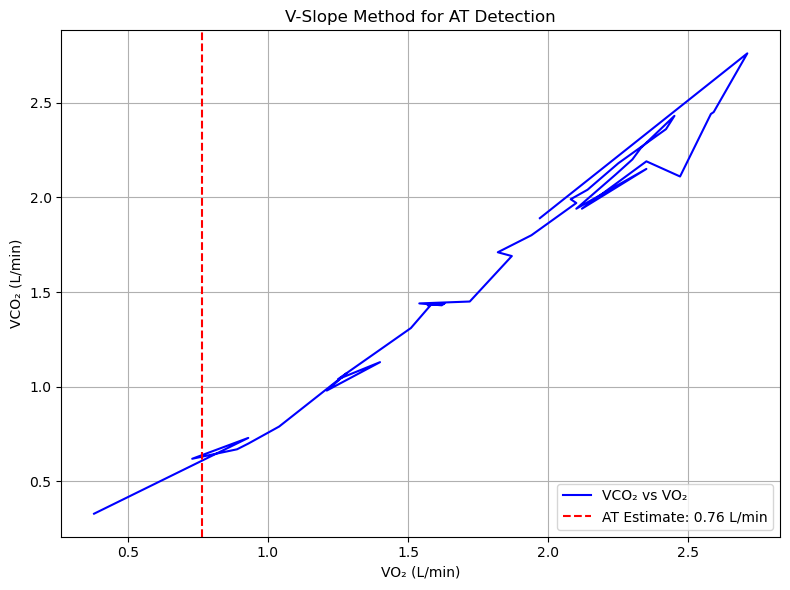

In [528]:
import matplotlib.pyplot as plt

def plot_vslope_breakpoint(df, at_vo2):
    df_vs = df[['VO2', 'VCO2']].dropna().reset_index(drop=True)
    plt.figure(figsize=(8, 6))
    plt.plot(df_vs['VO2'], df_vs['VCO2'], label='VCO₂ vs VO₂', color='blue')
    plt.axvline(x=at_vo2, color='red', linestyle='--', label=f'AT Estimate: {at_vo2:.2f} L/min')
    plt.xlabel('VO₂ (L/min)')
    plt.ylabel('VCO₂ (L/min)')
    plt.title('V-Slope Method for AT Detection')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call this only if V-slope AT was found
if at_vslope and not isinstance(at_vslope, str):
    plot_vslope_breakpoint(df_cpet, at_vslope)


In [529]:
def plot_ve_equivalents(df):
    df['VE/VO2_smooth'] = df['VE/VO2'].rolling(window=3, center=True).mean()
    df['VE/VCO2_smooth'] = df['VE/VCO2'].rolling(window=3, center=True).mean()
    
    plt.figure(figsize=(10, 5))
    plt.plot(df['VO2'], df['VE/VO2_smooth'], label='VE/VO₂ (smoothed)', color='blue')
    plt.plot(df['VO2'], df['VE/VCO2_smooth'], label='VE/VCO₂ (smoothed)', color='orange')
    plt.xlabel('VO₂ (L/min)')
    plt.ylabel('Ventilatory Equivalents')
    plt.title('VE/VO₂ and VE/VCO₂ Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ve_equivalents(df_cpet)


KeyError: 'VE/VCO2'

KeyError: 'VE/VCO2'

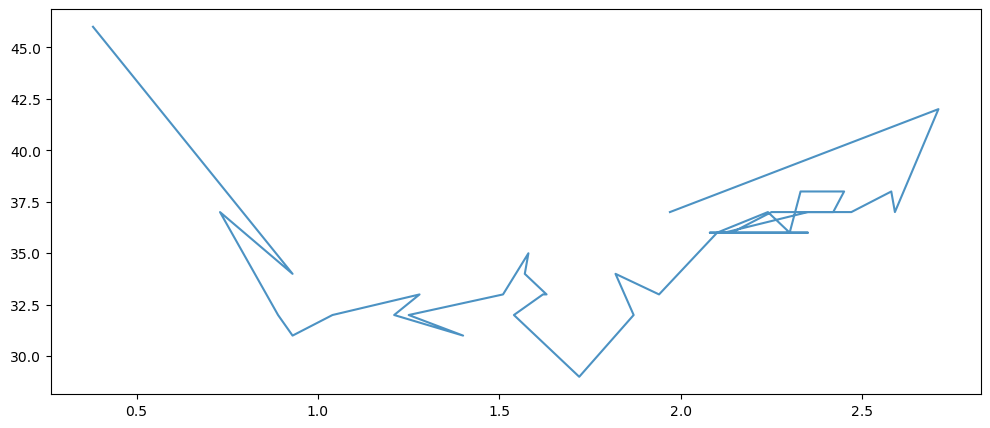

In [530]:
def debug_ve_inputs(df):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))
    plt.plot(df['VO2'], df['VE/VO2'], label='VE/VO2', alpha=0.8)
    plt.plot(df['VO2'], df['VE/VCO2'], label='VE/VCO2', alpha=0.8)
    plt.xlabel("VO2 (L/min)")
    plt.ylabel("Ratio")
    plt.legend()
    plt.title("Ventilatory Equivalents vs VO2")
    plt.grid()
    plt.show()

debug_ve_inputs(df_cpet)


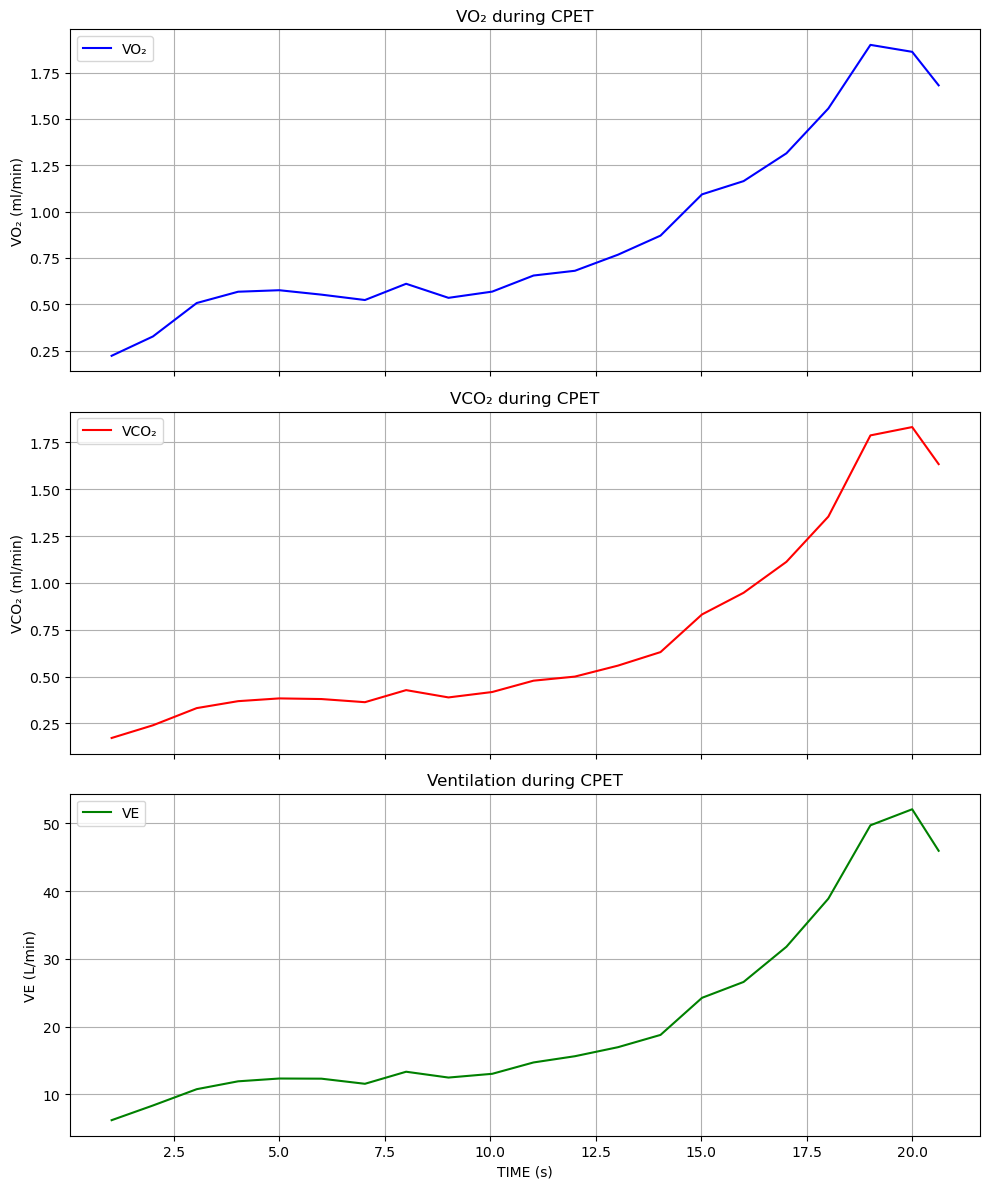

Anaerobic Threshold (V-slope method): VO2 = 0.7 ml/min, VCO2 = 0.5 ml/min


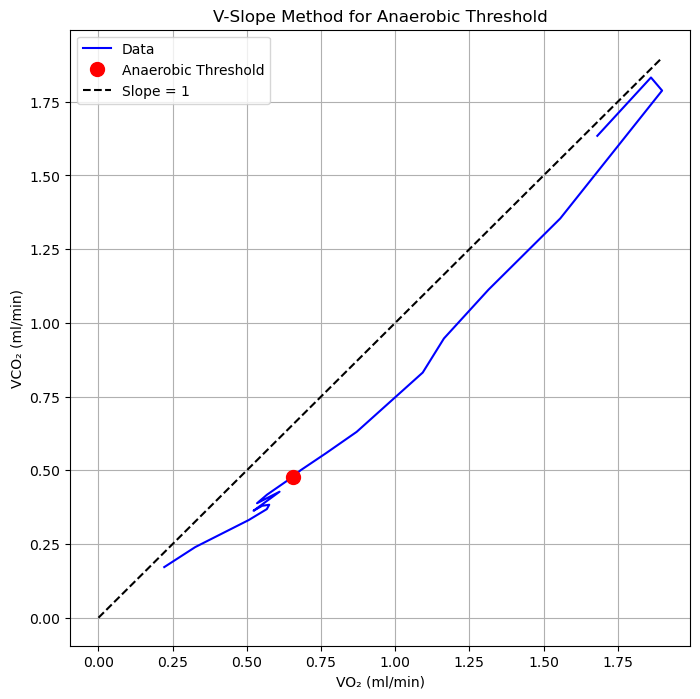

Anaerobic Threshold (Ventilatory Equivalents): VO2 = 0.6 ml/min at 4.0 s


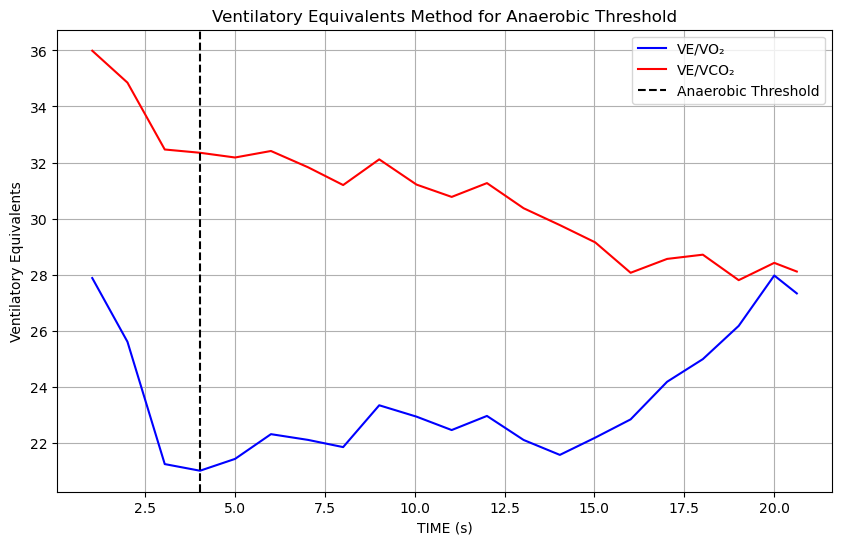

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load your CSV file
df = pd.read_csv('PCS01_V1_CPET.csv')
df.columns = df.columns.str.strip()  # Removes leading/trailing spaces from all column names

# Rename columns if needed (example if your time column is named differently)
# df = df.rename(columns={'OldTimeName': 'TIME'})

def plot_basic_data(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # Plot VO2
    ax1.plot(df['TIME'], df['VO2'], 'b-', label='VO₂')
    ax1.set_ylabel('VO₂ (ml/min)')
    ax1.set_title('VO₂ during CPET')
    ax1.grid(True)
    ax1.legend()
    
    # Plot VCO2
    ax2.plot(df['TIME'], df['VCO2'], 'r-', label='VCO₂')
    ax2.set_ylabel('VCO₂ (ml/min)')
    ax2.set_title('VCO₂ during CPET')
    ax2.grid(True)
    ax2.legend()
    
    # Plot VE
    ax3.plot(df['TIME'], df['VE'], 'g-', label='VE')
    ax3.set_ylabel('VE (L/min)')
    ax3.set_xlabel('TIME (s)')
    ax3.set_title('Ventilation during CPET')
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

plot_basic_data(df)

def v_slope_method(df):
    x = df['VO2'].values
    y = df['VCO2'].values
    
    slopes = []
    window_size = 10  # Adjust based on your data density
    
    for i in range(window_size, len(x)-window_size):
        x1 = x[i-window_size:i]
        y1 = y[i-window_size:i]
        x2 = x[i:i+window_size]
        y2 = y[i:i+window_size]
        
        slope1, _, _, _, _ = stats.linregress(x1, y1)
        slope2, _, _, _, _ = stats.linregress(x2, y2)
        slopes.append(slope2 - slope1)
    
    threshold_idx = np.argmax(np.abs(np.diff(slopes))) + window_size
    at_vo2 = x[threshold_idx]
    at_vco2 = y[threshold_idx]
    
    return at_vo2, at_vco2, threshold_idx

at_vo2, at_vco2, at_idx = v_slope_method(df)
print(f"Anaerobic Threshold (V-slope method): VO2 = {at_vo2:.1f} ml/min, VCO2 = {at_vco2:.1f} ml/min")

def plot_v_slope(df, at_vo2, at_vco2):
    plt.figure(figsize=(8, 8))
    
    plt.plot(df['VO2'], df['VCO2'], 'b-', label='Data')
    plt.plot(at_vo2, at_vco2, 'ro', markersize=10, label='Anaerobic Threshold')
    
    max_val = max(df['VO2'].max(), df['VCO2'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', label='Slope = 1')
    
    plt.xlabel('VO₂ (ml/min)')
    plt.ylabel('VCO₂ (ml/min)')
    plt.title('V-Slope Method for Anaerobic Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_v_slope(df, at_vo2, at_vco2)

def ventilatory_equivalents_method(df):
    df['VE/VO2'] = df['VE'] / df['VO2']
    df['VE/VCO2'] = df['VE'] / df['VCO2']
    
    ve_vo2_diff = np.diff(df['VE/VO2'])
    ve_vco2_diff = np.diff(df['VE/VCO2'])
    
    threshold_idx = np.argmax(ve_vo2_diff > ve_vco2_diff)
    
    at_vo2 = df['VO2'].iloc[threshold_idx]
    at_time = df['TIME'].iloc[threshold_idx]
    
    return at_vo2, at_time, threshold_idx

at_vo2_ve, at_time_ve, at_idx_ve = ventilatory_equivalents_method(df)
print(f"Anaerobic Threshold (Ventilatory Equivalents): VO2 = {at_vo2_ve:.1f} ml/min at {at_time_ve:.1f} s")

def plot_ventilatory_equivalents(df, at_idx):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(df['TIME'], df['VE/VO2'], 'b-', label='VE/VO₂')
    ax.plot(df['TIME'], df['VE/VCO2'], 'r-', label='VE/VCO₂')
    ax.axvline(x=df['TIME'].iloc[at_idx], color='k', linestyle='--', label='Anaerobic Threshold')
    
    ax.set_xlabel('TIME (s)')
    ax.set_ylabel('Ventilatory Equivalents')
    ax.set_title('Ventilatory Equivalents Method for Anaerobic Threshold')
    ax.grid(True)
    ax.legend()
    
    plt.show()

plot_ventilatory_equivalents(df, at_idx_ve)

## Plot 2

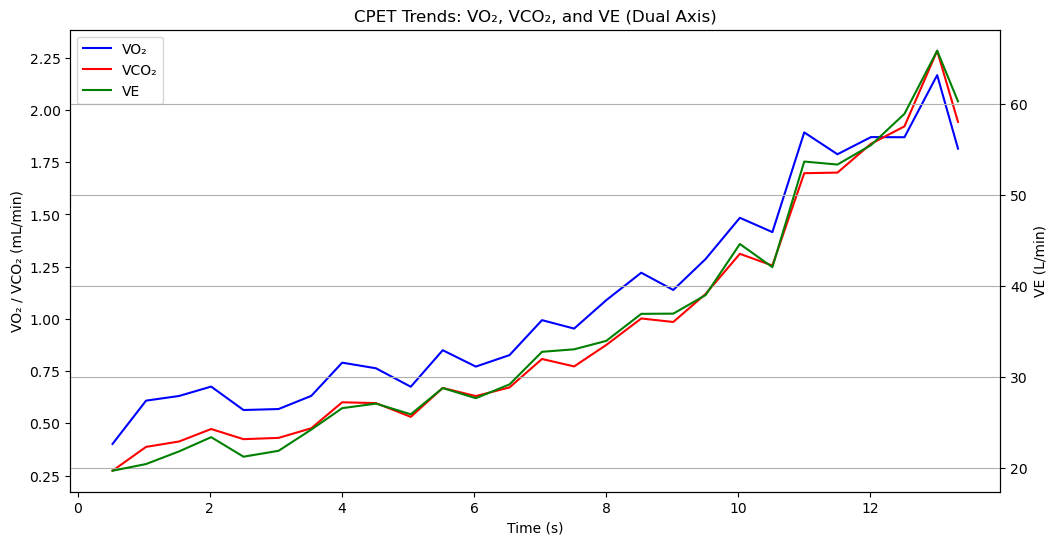

In [98]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot VO2 and VCO2 on primary axis
ax1.plot(df_cpet['TIME'], df_cpet['VO2'], 'b-', label='VO₂')
ax1.plot(df_cpet['TIME'], df_cpet['VCO2'], 'r-', label='VCO₂')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('VO₂ / VCO₂ (mL/min)')

# Create secondary axis for VE
ax2 = ax1.twinx()
ax2.plot(df_cpet['TIME'], df_cpet['VE'], 'g-', label='VE')
ax2.set_ylabel('VE (L/min)')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('CPET Trends: VO₂, VCO₂, and VE (Dual Axis)')
plt.grid(True)
plt.show()

### Plot 3

NameError: name 'AT_vslope_index' is not defined

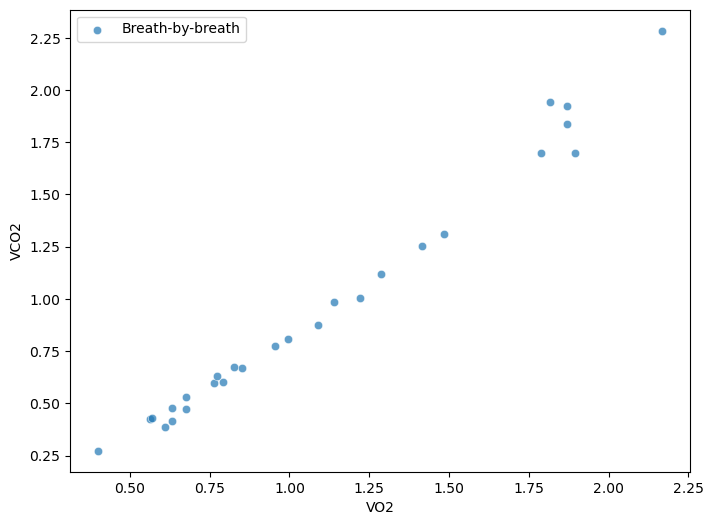

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your data is sorted and averaged every 20 seconds
# Assuming df_cpet has columns: 'Time', 'VO2', 'VCO2', 'AT_Vslope_Index'

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cpet, x='VO2', y='VCO2', alpha=0.7, label='Breath-by-breath')
plt.axvline(df_cpet.loc[AT_vslope_index, 'VO2'], color='red', linestyle='--', label='AT (V-slope)')

plt.title('Modified V-slope Method')
plt.xlabel('VO₂ (L/min)')
plt.ylabel('VCO₂ (L/min)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'AT_venteq_index' is not defined

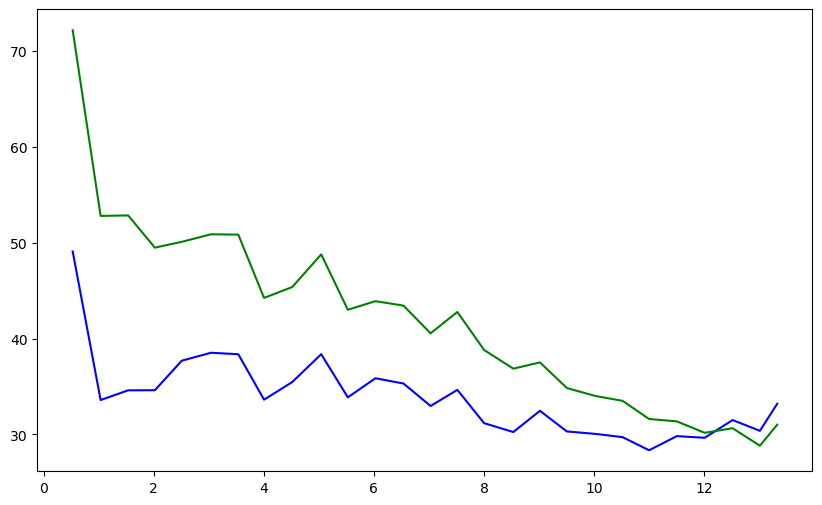

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(df_cpet['TIME'], df_cpet['VE/VO2'], label='VE/VO₂', color='blue')
plt.plot(df_cpet['TIME'], df_cpet['VE/VCO2'], label='VE/VCO₂', color='green')
plt.axvline(df_cpet.loc[AT_venteq_index, 'Time'], color='red', linestyle='--', label='AT (VE Method)')

plt.title('Ventilatory Equivalent Method')
plt.xlabel('Time (s)')
plt.ylabel('VE/VO₂ and VE/VCO₂')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


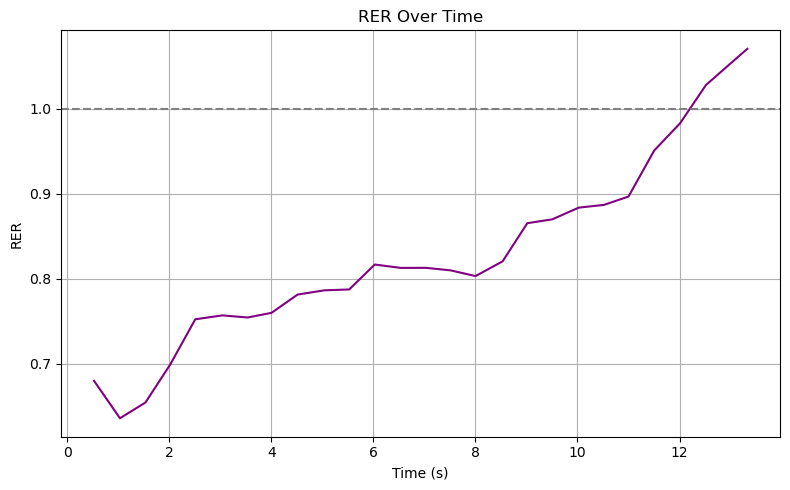

In [96]:
plt.figure(figsize=(8, 5))
plt.plot(df_cpet['TIME'], df_cpet['RER'], label='RER', color='purple')
plt.axhline(1.0, color='gray', linestyle='--')
plt.title('RER Over Time')
plt.xlabel('Time (s)')
plt.ylabel('RER')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
# For each patient:
patient_df = pd.read_csv("PCS01_V1_CPET.csv")
results = analyze_cpet_data(patient_df, patient_weight_kg=75)

# Print formatted results
print("CPET Results:")
for k, v in results.items():
    print(f"{k:<25}: {v}")

CPET Results:
VO2 Peak (L/min)         : 1.90
VO2 Peak (mL/kg/min)     : 25.3
AT (VE/VO2)              : Undetermined: No clear ventilatory threshold detected
AT (V-slope)             : 1.09 L/min
VE/VCO2 at V-slope AT    : 29.2
O2 Pulse at Peak         : nan mL/beat


# FMD

In [521]:
# Import the FMD dataset as df_fmd

filename = "PCS01_V1_FMD.csv"

df_fmd2 = pd.read_csv(filename, engine='python')


df_fmd = pd.read_csv(filename, skiprows=7, skipfooter=2, engine='python')

# Convert 'Time [min:sec]' to total seconds
df_fmd[['Minutes', 'Seconds']] = df_fmd['Time [min:sec]'].str.split(':', expand=True).astype(float)
df_fmd['Time_seconds'] = df_fmd['Minutes'] * 60 + df_fmd['Seconds']
df_fmd.drop(columns=['Minutes', 'Seconds'], inplace=True)

# Remove rows with missing values in key columns
df_fmd_clean = df_fmd.dropna(subset=['Mean Diameter [mm]', 'Positive Shear Rate [sec-1]', 
                                      'Negative Shear Rate [sec-1]', 'Positive Velocity [cm/sec]', 
                                      'Negative Velocity [cm/sec]'])

# Define baseline and hyperemia periods based on time
baseline_period = df_fmd_clean[df_fmd_clean['Time_seconds'] < 60]  # First 60 sec
hyperemia_period = df_fmd_clean[(df_fmd_clean['Time_seconds'] >= 420) & (df_fmd_clean['Time_seconds'] < 480)]  # 7 to 8 min

# Diameter Baseline
diameter_baseline = baseline_period['Mean Diameter [mm]'].mean() / 10  # Convert mm to cm

# Diameter Maximum
df_fmd['Mean Diameter [mm]'] = pd.to_numeric(df_fmd['Mean Diameter [mm]'], errors='coerce')
diameter_max = hyperemia_period['Mean Diameter [mm]'].max() / 10  # Convert mm to cm

# FMD Percent
fmd_percent = ((diameter_max - diameter_baseline) / diameter_baseline) * 100

# Shear Rate
shear_rate_baseline = df_fmd2['Positive Shear Rate Baseline [sec-1]'][0]
shear_rate_maximum = df_fmd2['Positive Shear Rate Maximum [sec-1]'][0]
shear_rate_areatomaximum = df_fmd2['Positive Shear Rate Area to Maximum []'][0]

# Hyperemia Shear Rate Max AUC
shear_rate_auc = trapz(4 * hyperemia_period['Positive Velocity [cm/sec]'] / hyperemia_period['Mean Diameter [mm]'])

# Mean Velocity
velocity_baseline = df_fmd2['Positive Velocity Baseline [cm/sec]'][0]
velocity_maximum = df_fmd2['Positive Velocity Maximum [cm/sec]'][0]
velocity_mean = df_fmd['Positive Velocity [cm/sec]'].mean()

# Flow Rate
flow_rate = (3.1416 * ((df_fmd['Mean Diameter [mm]'] / 10) / 2) ** 2 * df_fmd['Positive Velocity [cm/sec]'] * 60).mean()

# FMD Normalized
fmd_normalized = fmd_percent / shear_rate_auc

print(f"Diameter Baseline (cm): {diameter_baseline:.3f}")
print(f"Diameter Maximum (cm): {diameter_max:.3f}")
print(f"FMD (%): {fmd_percent:.2f}")
print(f"Shear Rate Baseline (s⁻¹): {shear_rate_baseline:.2f}")
print(f"Shear Rate Maximum (s⁻¹): {shear_rate_maximum:.2f}")
print(f"Shear Rate Area to Maximum (s⁻¹): {shear_rate_areatomaximum:.2f}")
print(f"Hyperemia Shear Rate Max (AUC): {shear_rate_auc:.2f}")
print(f"Baseline Velocity (cm/s): {velocity_baseline:.2f}")
print(f"Maximum Velocity (cm/s): {velocity_maximum:.2f}")
print(f"Mean Velocity (cm/s): {velocity_mean:.2f}")
print(f"Flow Rate (ml/min): {flow_rate:.2f}")
print(f"FMD Normalized: {fmd_normalized:.5f}")


Diameter Baseline (cm): 0.328
Diameter Maximum (cm): 0.342
FMD (%): 4.22
Shear Rate Baseline (s⁻¹): 91.81
Shear Rate Maximum (s⁻¹): 376.14
Shear Rate Area to Maximum (s⁻¹): 7166.20
Hyperemia Shear Rate Max (AUC): 638.16
Baseline Velocity (cm/s): 7.53
Maximum Velocity (cm/s): 30.38
Mean Velocity (cm/s): 8.68
Flow Rate (ml/min): 45.09
FMD Normalized: 0.00661


C:\Users\ZCooper\AppData\Local\Temp\ipykernel_24904\3679860908.py:40: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  shear_rate_auc = trapz(4 * hyperemia_period['Positive Velocity [cm/sec]'] / hyperemia_period['Mean Diameter [mm]'])


Diameter Baseline (cm): 0.427
Diameter Maximum (cm): 0.475
FMD (%): 11.32
Shear Rate Baseline (s⁻¹): 325.15
Shear Rate Maximum (s⁻¹): 894.22
Shear Rate Area to Maximum (s⁻¹): 19562.50
Hyperemia Shear Rate Max (AUC): 2197.76
Baseline Velocity (cm/s): 34.70
Maximum Velocity (cm/s): 97.44
Mean Velocity (cm/s): 29.97
Flow Rate (ml/min): 282.98
FMD Normalized: 0.00515


C:\Users\ZCooper\AppData\Local\Temp\ipykernel_24904\1023748718.py:31: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  shear_rate_auc = trapz(4 * hyperemia_period['Positive Velocity [cm/sec]'] / hyperemia_period['Mean Diameter [mm]'])


[]


# PetCo2

In [464]:
import pandas as pd
import numpy as np

# Constants
baro_pressure = 762.4  # mmHg
ph2o = 47  # mmHg

# Calculate PETCO2 (assuming FECO2 is in %)
df_cpet['PETCO2'] = (df_cpet['FECO2'] / 100) * (baro_pressure - ph2o)

# --- 1. PETCO2 at Peak VO2 ---
max_vo2_idx = df_cpet['VO2'].idxmax()
petco2_at_max_vo2 = df_cpet.loc[max_vo2_idx, 'PETCO2']

# --- 2. PETCO2 at AT (V-slope method) ---
# Find the row index closest to the V-slope AT value (assuming 'VO2' is the x-axis)
at_vslope_idx = (df_cpet['VO2'] - at_vslope).abs().idxmin()
petco2_at_vslope = df_cpet.loc[at_vslope_idx, 'PETCO2']

# --- 3. PETCO2 at AT (Ventilatory Equivalent Method - VEM) ---
# Find the row index closest to the VE/VO2 AT value
at_venteq_idx = (df_cpet['VO2'] - at_venteq).abs().idxmin()
petco2_at_vem = df_cpet.loc[at_venteq_idx, 'PETCO2']

# --- Print Results ---
print(f"PETCO2 at peak VO2: {petco2_at_max_vo2:.1f} mmHg")
print(f"PETCO2 at AT (V-slope, VO2={at_vslope:.1f} mL/min): {petco2_at_vslope:.1f} mmHg")
print(f"PETCO2 at AT (VE/VO2, VO2={at_venteq:.1f} mL/min): {petco2_at_vem:.1f} mmHg")

PETCO2 at peak VO2: 31.3 mmHg
PETCO2 at AT (V-slope, VO2=0.8 mL/min): 28.7 mmHg
PETCO2 at AT (VE/VO2, VO2=0.6 mL/min): 27.1 mmHg


# Day / Time

In [28]:
import pandas as pd
from datetime import datetime

def get_visit_datetime(filepath):
    try:
        # Read only the needed rows (now checking row 3: B3, D3, F3)
        df = pd.read_excel(
            filepath, 
            header=None, 
            nrows=4,  # Read up to row 4 to ensure row 3 is included
            usecols="B,D,F", 
            engine="xlrd"
        )
        
        # Extract year (B3), month (D3), day (F3)
        year = int(df.iloc[2, 0])   # B3 (row index 2 since Python is 0-based)
        month = int(df.iloc[2, 1])  # D3
        day = int(df.iloc[2, 2])    # F3
        
        return datetime(year, month, day)
    
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

subject = "20"

# File paths
file_v1 = "PCS" + subject + "_V1_CPET.xls"
file_v2 = "PCS" + subject + "_V2_CPET.xls"

start_date = get_visit_datetime(file_v1)
end_date = get_visit_datetime(file_v1)

if start_date and end_date:
    print("✅ Start date:", start_date)
    print("✅ End date:", end_date)
else:
    print("❌ Failed to read dates from one or both files.")

*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
✅ Start date: 2025-07-13 00:00:00
✅ End date: 2025-07-13 00:00:00


In [2]:
pip install --upgrade xlrd


^C
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable


# End